In [1]:
# install library
# Data loading, PhysioNet
# HRV extraction, signal processing
# Data balancing, SMOTE
# Interpretability, feature importance
# Useful for creating clear, publication-quality figures

!pip install wfdb neurokit2 imbalanced-learn shap seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 87.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install matplotlib
!pip install numpy==1.23
!pip uninstall matplotlib numpy --y
!pip install matplotlib numpy==1.23

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 96.5 MB/s eta 0:00:00:00:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.0-cp311-cp311-linux_x86_64.whl size=19730037 sha256=42bf44cbd310ac69a056196d26e770e868724a07b1b8edbfd39acfb3094a06b3
  Stored in directory: /root/.cache/pip/wheels/6d/36/1a/3ec6b85008bea3151efb003f5d41baa7bf4966cb43c1c2470b
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.3.0 requires numpy>=1.26.4, but you have numpy 1.23.0 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import os
import wfdb
import math
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import neurokit2 as nk
import cv2
from scipy.signal import butter, filtfilt
import pywt

# Specify the directory where you want to save the downloaded files.
download_dir = 'mitdb_data' 

In [4]:
# Check if the directory exists and contains files
# download_dir is the directory where to save the data
if not os.path.exists('/mitdb_data') or not os.listdir('/mitdb_data'):
    # download the data
    wfdb.dl_database('mitdb', dl_dir=download_dir)
    print("Download complete. Files are saved in:", download_dir)
else:
    print("Dataset already exists in:", download_dir)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

# Get Signal Frame Info

In [5]:
# Step 1: Get a list of record names (without extensions)
# Direct access all types of the records
# mitdb is official site
record_list = wfdb.get_record_list('mitdb')
print(f"\nTotal records found: {len(record_list)}")

# Step 2: Dictionary to store number of samples per record
record_samples = {}

# Step 3: Read signals and store number of samples
print("\nReading signals and collecting information...")
for record in record_list:
    record_path = os.path.join(download_dir, record)
    try:
        # rdsamp to read the .hea and .dat files
        # Read the ECG signal and metadata from the record using wfdb.rdsamp()
        signal, fields = wfdb.rdsamp(record_path)
        num_samples = len(signal)
        record_samples[record] = num_samples
    except Exception as e:
        print(f"Failed to read record {record}: {e}")

# Step 4: Display results
print("\nRecord Information:")
for record, samples in record_samples.items():
    duration_sec = samples / 360  # Sampling rate is 360 Hz
    duration_min = duration_sec / 60
    print(f"Record: {record}")
    print(f"  Samples: {samples}")
    print(f"  Duration: {duration_sec:.2f} seconds ({duration_min:.2f} minutes)\n")

# Step 5: Show total number of frames (samples)
total_samples = sum(record_samples.values())
total_duration_sec = total_samples / 360
total_duration_min = total_duration_sec / 60

print(f"Total Samples: {total_samples}")
print(f"Total Duration: {total_duration_sec:.2f} seconds ({total_duration_min:.2f} minutes)")


Total records found: 48

Reading signals and collecting information...

Record Information:
Record: 100
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 101
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 102
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 103
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 104
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 105
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 106
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 107
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 108
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 109
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 111
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record: 112
  Samples: 650000
  Duration: 1805.56 seconds (30.09 minutes)

Record:

# Interaction Widget

# Signal Processing Widgets


In [6]:
import os
import numpy as np
import wfdb
import cv2
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# Define MIT-BIH data directory
download_dir = '/kaggle/working/mitdb_data'

# List of valid record IDs
# List of the records that can be selected in the interactive widgets
valid_records = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119',
    '121', '122', '123', '124', '200', '201', '202', '203', '205',
    '207', '208', '209', '210', '212', '213', '214', '215', '217',
    '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234'
]

def ecg_preprocessing_visualization():
    # Define interactive widgets
    record_selector = widgets.Dropdown(options=valid_records, value='100', description='Record:')
    
    start_time = widgets.FloatSlider(value=0.0, min=0, max=30, step=0.5, description='Start Time (min):')
    
    view_duration = widgets.FloatSlider(value=2.0, min=0.5, max=10.0, step=0.5, description='Duration (s):')
    
    # Reduce Noise
    # Can Mantain more details if small kernal
    gaussian_kernel_slider = widgets.IntSlider(value=5, min=1, max=15, step=2, description='Gaussian Kernel')

    # Remove low frequency noise from the signal
    # Low - More low frequency signals will be allowed to pass, possibly preserving more baseline 
    # wander or low frequency components of the signal, but more noise will also be preserved.
    hp_cutoff_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='HP Cutoff (Hz)')
    
    ma_window_slider = widgets.IntSlider(value=50, min=10, max=100, step=10, description='MA Window (ms)')

    # High - Allows more high-frequency content to be removed, but may also remove some detail, 
    # particularly in the low-frequency portion of the signal.
    wavelet_level_slider = widgets.IntSlider(value=5, min=1, max=8, description='Wavelet Level')
    
    phase_selector = widgets.Dropdown(
        options=['Gaussian', 'HighPass', 'Moving Average', 'Wavelet'],
        value='Gaussian',
        description='Phase:'
    )
    
    raw_color_picker = widgets.ColorPicker(value='black', concise=True, description='Raw Color')
    
    phase_color_picker = widgets.ColorPicker(value='blue', concise=True, description='Phase Color')

    # Define update function
    def update_display(record_id, start_min, duration_sec,
                       gaussian_kernel, hp_cutoff, ma_window, wavelet_level, phase,
                       raw_color, phase_color):
        
        # Load ECG data from download_dir
        record_path = os.path.join(download_dir, record_id)
        record = wfdb.rdrecord(record_path)
        fs = record.fs
        ecg = record.p_signal[:, 0]

        # Extract window
        start_sample = int(start_min * 60 * fs)
        end_sample = int(start_sample + duration_sec * fs)
        raw = ecg[start_sample:end_sample]
        t = np.arange(len(raw)) / fs

        # Gaussian filtering
        if gaussian_kernel % 2 == 0:
            gaussian_kernel += 1
        gaussian_filtered = cv2.GaussianBlur(raw.astype('float32').reshape(-1,1),
                                             (gaussian_kernel, gaussian_kernel), 0).flatten()

        # High-pass filtering
        b, a = butter(2, hp_cutoff / (0.5 * fs), btype='high')
        highpass_filtered = filtfilt(b, a, gaussian_filtered)

        # Moving average filtering
        ma_window_samples = int(fs * ma_window / 1000)
        ma_filtered = np.convolve(highpass_filtered,
                                  np.ones(ma_window_samples)/ma_window_samples,
                                  mode='same')

        # Wavelet denoising
        wavelet = 'db6'
        coeffs = pywt.wavedec(ma_filtered, wavelet, level=wavelet_level)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        uthresh = sigma * np.sqrt(2 * np.log(len(ma_filtered)))
        denoised_coeffs = [pywt.threshold(c, value=uthresh, mode='soft') if i > 0 else c
                           for i, c in enumerate(coeffs)]
        wavelet_filtered = pywt.waverec(denoised_coeffs, wavelet)
        wavelet_filtered = wavelet_filtered[:len(t)]  # Trim to match length

        # Select current phase output
        phase_signal = {
            'Gaussian': gaussian_filtered,
            'HighPass': highpass_filtered,
            'Moving Average': ma_filtered,
            'Wavelet': wavelet_filtered
        }.get(phase, gaussian_filtered)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(t, raw, color=raw_color, label='Raw ECG')
        plt.plot(t, phase_signal, color=phase_color, label=f'{phase} Filtered')
        plt.title(f'ECG Record {record_id} | Phase: {phase}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Create interactive display
    ui = widgets.VBox([
        widgets.HBox([record_selector, start_time, view_duration]),
        widgets.HBox([gaussian_kernel_slider, hp_cutoff_slider, ma_window_slider, wavelet_level_slider]),
        widgets.HBox([phase_selector, raw_color_picker, phase_color_picker])
    ])

    out = widgets.interactive_output(
        update_display,
        {
            'record_id': record_selector,
            'start_min': start_time,
            'duration_sec': view_duration,
            'gaussian_kernel': gaussian_kernel_slider,
            'hp_cutoff': hp_cutoff_slider,
            'ma_window': ma_window_slider,
            'wavelet_level': wavelet_level_slider,
            'phase': phase_selector,
            'raw_color': raw_color_picker,
            'phase_color': phase_color_picker
        }
    )

    display(ui, out)


In [7]:
ecg_preprocessing_visualization()


In [8]:
import plotly.graph_objects as go
import plotly.io as pio

# Global cache for loaded record and annotation
cached_record = None
cached_annotation = None
cached_record_num = None

def load_record_data(record_num, sampfrom=0, sampto=None):
    """Load full record and annotation, then cache it."""
    global cached_record, cached_annotation, cached_record_num
    record_path = os.path.join(download_dir, record_num)
    # Load the full record if sampto is not provided
    full_record = wfdb.rdrecord(record_path) if sampto is None else wfdb.rdrecord(record_path, sampfrom=sampfrom, sampto=sampto)
    ann = wfdb.rdann(record_path, 'atr')
    cached_record = full_record
    cached_annotation = ann
    cached_record_num = record_num

def plot_record_with_annotations_plotly_cached(sampfrom, sampto, segment_duration=5.0):
    """Plot a segment from the cached record and annotation."""
    global cached_record, cached_annotation, cached_record_num
    if cached_record is None or cached_annotation is None:
        print("No record loaded.")
        return go.Figure()

    fs = cached_record.fs  # Sampling frequency
    # Adjust sampto if needed
    if sampto > cached_record.sig_len:
        sampto = cached_record.sig_len

    # Extract the desired segment from the cached record
    # Note: cached_record.p_signal contains the full signal data
    signal = cached_record.p_signal[sampfrom:sampto, 0]
    time = np.arange(sampfrom, sampto) / fs  # Time axis in seconds

    # Create a Plotly figure
    fig = go.Figure()
    
    # Add ECG signal trace
    fig.add_trace(go.Scatter(x=time, y=signal,
                             mode='lines',
                             name='ECG Signal'))
    
    # Process annotations that fall within the segment
    ann_indices = np.array(cached_annotation.sample)
    ann_mask = (ann_indices >= sampfrom) & (ann_indices < sampto)
    ann_indices_seg = ann_indices[ann_mask]
    ann_symbols = np.array(cached_annotation.symbol)[ann_mask]
    ann_times = (ann_indices_seg - sampfrom) / fs  # Relative times in seconds

    # Add annotation vertical lines and text
    for t, sym in zip(ann_times, ann_symbols):
        fig.add_shape(type="line",
                      x0=t, x1=t,
                      y0=min(signal), y1=max(signal),
                      line=dict(color="red", dash="dash"))
        fig.add_annotation(x=t, y=max(signal),
                           text=sym,
                           showarrow=True,
                           arrowhead=1,
                           ax=0, ay=-20,
                           font=dict(color="red"))
    
    # Add segmentation lines (every segment_duration seconds)
    segment_length = int(segment_duration * fs)  # Number of samples per segment
    for i in range(sampfrom, sampto, segment_length):
        t_seg = (i - sampfrom) / fs
        fig.add_shape(type="line",
                      x0=t_seg, x1=t_seg,
                      y0=min(signal), y1=max(signal),
                      line=dict(color="green", dash="dot"))
    
    # Update layout
    fig.update_layout(title=f"Record {cached_record_num} - Annotations (Samples {sampfrom} to {sampto})",
                      xaxis_title="Time (seconds)",
                      yaxis_title="ECG Signal",
                      autosize=False,
                      width=1000, height=500)
    
    return fig

# Create interactive widgets
record_selector = widgets.Dropdown(
    options=[(f'Record {i}', str(i)) for i in range(100, 116)],
    value='100',
    description='Record:'
)

# Adjust the slider range (end_slider max is 650000)
start_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=650000,
    step=1000,
    description='Start:',
    continuous_update=False
)

end_slider = widgets.IntSlider(
    value=5000,
    min=1000,
    max=650000,
    step=1000,
    description='End:',
    continuous_update=False
)

# Create an output widget for the plot
plot_output = widgets.Output()

def update_plot(change=None):
    with plot_output:
        plot_output.clear_output(wait=True)
        # Ensure that the end value is greater than the start value
        if end_slider.value <= start_slider.value:
            print("End value must be greater than Start value")
            return
        fig = plot_record_with_annotations_plotly_cached(start_slider.value,
                                                         end_slider.value)
        fig.show()

def on_record_change(change):
    # When record changes, load the full record once and update the plot
    load_record_data(change['new'])
    update_plot()

# Attach observers: When record changes, load data; when sliders change, update the plot
record_selector.observe(on_record_change, names='value')
start_slider.observe(update_plot, names='value')
end_slider.observe(update_plot, names='value')

# Display widgets and plot output
display(widgets.VBox([record_selector, start_slider, end_slider, plot_output]))

# Load the initial record
load_record_data(record_selector.value)
update_plot()

# Preprocessing Record

In [9]:
import os
import wfdb
import numpy as np
import pandas as pd
import cv2
import pywt
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from tqdm import tqdm

# Define normal symbol set
normal_symbols = {'N','L','R','e','j'}  # Only these symbols are considered normal

# Ref: https://archive.physionet.org/physiobank/annotations.shtml
symbol_description = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Right bundle branch block beat',
    'B': 'Bundle branch block beat (unspecified)',
    'A': 'Atrial premature beat',
    'a': 'Aberrated atrial premature beat',
    'J': 'Nodal (junctional) premature beat',
    'S': 'Supraventricular premature or ectopic beat',
    'V': 'Premature ventricular contraction',
    'r': 'R-on-T premature ventricular contraction',
    'F': 'Fusion of ventricular and normal beat',
    'e': 'Atrial escape beat',
    'j': 'Nodal (junctional) escape beat',
    'n': 'Supraventricular escape beat',
    'E': 'Ventricular escape beat',
    '/': 'Paced beat',
    'f': 'Fusion of paced and normal beat',
    'Q': 'Unclassifiable beat',
    '?': 'Beat not classified during learning',
    '[': 'Start of ventricular flutter/fibrillation',
    '!': 'Ventricular flutter wave',
    ']': 'End of ventricular flutter/fibrillation',
    'x': 'Non-conducted P-wave (blocked APC)',
    '(': 'Waveform onset',
    ')': 'Waveform end',
    'p': 'Peak of P-wave',
    't': 'Peak of T-wave',
    'u': 'Peak of U-wave',
    '`': 'PQ junction',
    "'": 'J-point',
    '^': '(Non-captured) pacemaker artifact',
    '|': 'Isolated QRS-like artifact',
    '~': 'Change in signal quality',
    '+': 'Rhythm change',
    's': 'ST segment change',
    'T': 'T-wave change',
    '*': 'Systole',
    'D': 'Diastole',
    '=': 'Measurement annotation',
    '"': 'Comment annotation',
    '@': 'Link to external data'
}

def process_record(record_name, segment_duration_minutes=5.00):
    try:
        # Read the records from the download_dir
        record_path = os.path.join(download_dir, record_name)
        if not os.path.exists(record_path + '.hea'):
            return None

        # Read out the annotations
        record = wfdb.rdrecord(record_path)
        ann = wfdb.rdann(record_path, 'atr')
        
        # Get raw ECG signal
        ecg_signal = record.p_signal[:, 0]
        
        # Signal preprocessing pipeline with error handling
        try:
            signal = ecg_signal.astype('float32')
            gaussian_filtered = cv2.GaussianBlur(signal.reshape(-1, 1), (5, 5), 0).flatten()

            # High-pass filter (0.5Hz cutoff)
            nyq = 0.5 * record.fs  # Nyquist frequency
            high = 0.10 / nyq      # Normalize cutoff
            b, a = butter(2, high, btype='high')
            hp_filtered = filtfilt(b, a, gaussian_filtered)

            # Moving average filter (50ms window)
            window_size = int(record.fs * 0.02)
            ma_filtered = np.convolve(hp_filtered, np.ones(window_size)/window_size, mode='same')

            # Wavelet-based baseline removal
            try:
                coeffs = pywt.wavedec(ma_filtered, 'db6', level=7)
                coeffs[0] = np.zeros_like(coeffs[0])
                baseline_removed = pywt.waverec(coeffs, 'db6')
            except Exception as e:
                print(f"Wavelet error in {record_name}: {str(e)} - using MA filtered signal")
                baseline_removed = ma_filtered
            
            baseline_removed = baseline_removed[:len(ecg_signal)]
        except Exception as e:
            print(f"Preprocessing failed for {record_name}: {str(e)}")
            return None

        # Signal segmentation
        segment_length_samples = int(segment_duration_minutes * 60 * record.fs)
        total_samples = len(baseline_removed)
        num_segments = total_samples // segment_length_samples

        # Segmentation length decided by the segment_length_samples
        segments = []
        for i in range(num_segments):
            start_idx = i * segment_length_samples
            end_idx = start_idx + segment_length_samples
            segment_signal = baseline_removed[start_idx:end_idx]
            
            # R-peak detection with validation to get the HRV features later
            try:
                info = nk.ecg_findpeaks(segment_signal, sampling_rate=record.fs, method="neurokit", show=False)
                peaks = info["ECG_R_Peaks"] if "ECG_R_Peaks" in info else []
                
                # Skip segment if insufficient beats detected
                # At least 10 to make the data reliable
                if len(peaks) < 10:  # Minimum 10 beats for HRV analysis
                    continue
                    
                # Calculate HRV features using the comprehensive wrapper
                hrv_features_df = nk.hrv(peaks, sampling_rate=record.fs, show=False)
                if hrv_features_df.empty:
                    continue
                hrv_features = hrv_features_df.iloc[0].to_dict()
                    
                exclude_keywords = [
                    "ULF", "SDNNI", "SDNNd", "SDNNa","SDANN",
                    "MFDFA", #  It requires long, continuous recordings to produce reliable patterns across time scales. In 5-minute data, the multifractal spectrum is often noisy and unstable.
                    "DFA",  # MFDFA — DFA α1 and α2 need longer time series to be meaningful.
                    "TINN",  # TINN depends heavily on histogram bin width and shape, which can be unstable or poorly defined in small samples.
                    "PIP", "IALS",  "PSS", "PAS", "GI",  # : These metrics are not well-validated, rarely used in clinical practice, and can show low interpretability.
                    "C1", "C2", "Ca", "Cd", # Require a high number of RR intervals to reliably calculate, In short segments (like 5 minutes), estimates can be unstable or heavily affected by noise.
                    "/","f","Q"
                ]
                
                filtered_hrv_features = {
                    k: v for k, v in hrv_features.items()
                    if not any(ex in k for ex in exclude_keywords)
                }

                # Extract annotations for the segment
                segment_ann_indices = np.where((ann.sample >= start_idx) & (ann.sample < end_idx))[0]
                segment_symbols = [ann.symbol[i] for i in segment_ann_indices]
                
                # New labeling logic: Only label as Normal if ALL beats are in normal_symbols
                if segment_symbols:
                    is_normal = all(sym in normal_symbols for sym in segment_symbols)
                    label = "Normal" if is_normal else "Abnormal"
                else:
                    # If no annotations, we'll consider it Normal (though this case should be rare)
                    label = "Normal"
                
                segments.append({
                    'record': record_name,
                    'segment': i + 1,
                    'symbols': segment_symbols,
                    'label': label,
                    **filtered_hrv_features,
                })
                
            except Exception as e:
                print(f"Segment {i+1} error in {record_name}: {str(e)}")
                continue

        return segments
        
    except Exception as e:
        print(f"Error processing {record_name}: {str(e)}")
        return None

# Get list of all record files in download directory
valid_records = [f.split('.')[0] for f in os.listdir(download_dir) if f.endswith('.hea')]

# Process all valid records
results = []
for record_id in tqdm(valid_records):
    segments = process_record(record_id)
    if segments:
        results.extend(segments)

# Create DataFrame and save results if any segments were processed
if results:
    df = pd.DataFrame(results)
    print("\nSuccessfully processed records:", len(df['record'].unique()))
    print("Total segments:", len(df))
    display(df.head())
    
    # Save Dataset
    df.to_csv("hrv_data.csv", index=False)
    print("\nData saved to hrv_data.csv")
else:
    print("No valid segments were processed")

100%|██████████| 48/48 [03:46<00:00,  4.73s/it]


Successfully processed records: 48
Total segments: 288


record  segment                                            symbols  \
0    223        1  [+, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...   
1    223        2  [N, N, N, N, N, N, N, N, N, N, N, N, N, V, N, ...   
2    223        3  [V, V, V, V, V, V, V, V, V, V, V, V, V, V, V, ...   
3    223        4  [N, A, A, N, N, N, N, N, N, N, N, N, N, N, N, ...   
4    223        5  [N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...   

      label  HRV_MeanNN    HRV_SDNN   HRV_RMSSD    HRV_SDSD  HRV_CVNN  \
0  Abnormal  738.456790   64.470851  103.850547  103.979269  0.087305   
1  Abnormal  692.881944   67.551583   89.218281   89.320279  0.097494   
2  Abnormal  666.641920   95.956360  148.352440  148.513507  0.143940   
3  Abnormal  676.313474   99.885872  161.885254  162.068904  0.147692   
4  Abnormal  693.039443  150.707117  296.889923  297.235747  0.217458   

   HRV_CVSD  ...  HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  \
0  0.140632  ...    1.098287    5.399576     0.803911  0.598927   1.256648   
1  0.128764  ...    1.259291    5.868073     0.800381  0.625295   1.262230   
2  0.222537  ...    0.771413    6.135400     0.676918  0.296224   1.102567   
3  0.239364  ...    0.617943    5.936829     0.604485  0.307694   1.058877   
4  0.428388  ...    0.328700    6.249148     0.394855  0.049071   0.654581   

   HRV_RCMSEn    HRV_CD   HRV_HFD    HRV_KFD   HRV_LZC  
0    1.284491  0.911625  1.968959   2.827934  0.941033  
1    1.347999  1.256032  2.042831   3.145116  0.810638  
2    1.099889  0.952583  2.039513   3.390437  0.745661  
3    0.994222  0.919980  2.007027   4.046459  0.755521  
4    0.583573  0.896820  2.247694  12.150914  0.609156  

[5 rows x 54 columns]


Data saved to hrv_data.csv


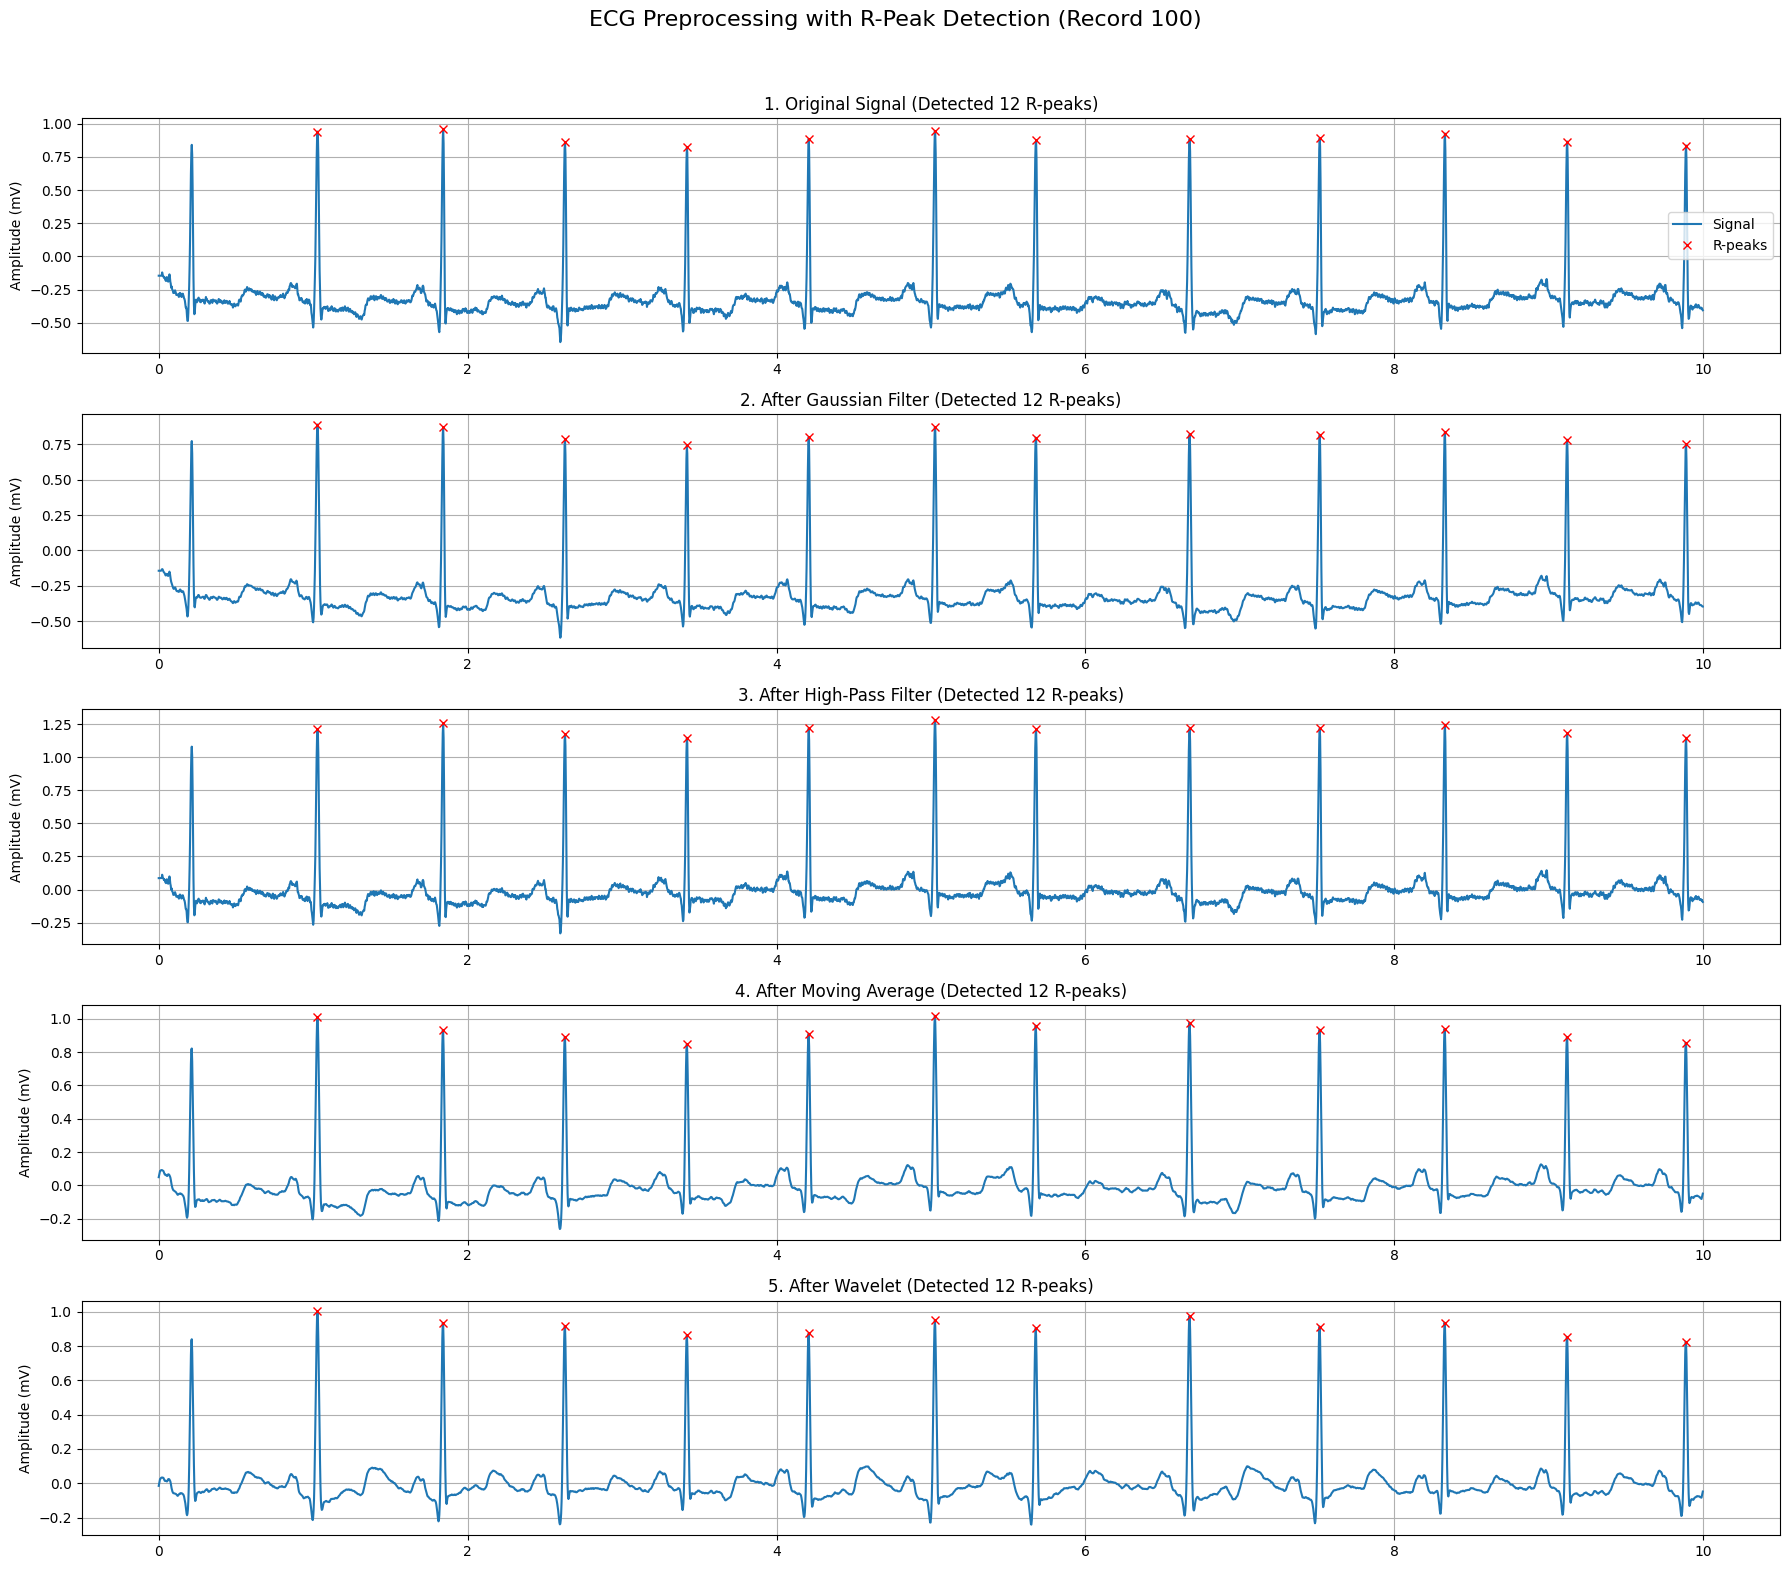


R-peak Detection Statistics:
Original: 12 peaks
After Gaussian: 12 peaks
After High-pass: 12 peaks
After Moving Avg: 12 peaks
After Wavelet: 12 peaks


In [10]:
def plot_preprocessing_with_rpeaks(record_name="100", start_second=0, duration_seconds=10):
    """Visualize preprocessing steps with R-peak detection at each stage"""
    try:
        record_path = os.path.join(download_dir, record_name)
        if not os.path.exists(record_path + '.hea'):
            print(f"Record {record_name} not found")
            return
            
        # Load the record
        record = wfdb.rdrecord(record_path)
        ecg_signal = record.p_signal[:, 0]
        fs = record.fs
        
        # Select segment for visualization
        start_sample = int(start_second * fs)
        end_sample = start_sample + int(duration_seconds * fs)
        time_axis = np.arange(start_sample, end_sample) / fs
        
        # Initialize plot
        plt.figure(figsize=(18, 18))
        plt.suptitle(f"ECG Preprocessing with R-Peak Detection (Record {record_name})", y=1.02, fontsize=16)
        
        # 1. Original Signal with R-peaks
        original = ecg_signal[start_sample:end_sample]
        peaks_original = nk.ecg_findpeaks(original, sampling_rate=fs, method="neurokit")["ECG_R_Peaks"]
        
        plt.subplot(6, 1, 1)
        plt.plot(time_axis, original, label='Signal')
        plt.plot(time_axis[peaks_original], original[peaks_original], 'rx', label='R-peaks')
        plt.title(f"1. Original Signal (Detected {len(peaks_original)} R-peaks)")
        plt.ylabel("Amplitude (mV)")
        plt.legend()
        plt.grid(True)
        
        # 2. After Gaussian Filter
        signal = ecg_signal.astype('float32')
        gaussian = cv2.GaussianBlur(signal.reshape(-1, 1), (5, 5), 0).flatten()[start_sample:end_sample]
        peaks_gaussian = nk.ecg_findpeaks(gaussian, sampling_rate=fs)["ECG_R_Peaks"]
        
        plt.subplot(6, 1, 2)
        plt.plot(time_axis, gaussian)
        plt.plot(time_axis[peaks_gaussian], gaussian[peaks_gaussian], 'rx')
        plt.title(f"2. After Gaussian Filter (Detected {len(peaks_gaussian)} R-peaks)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(True)
        
        # 3. After High-Pass Filter
        nyq = 0.5 * fs
        high = 0.10 / nyq
        b, a = butter(2, high, btype='high')
        highpass = filtfilt(b, a, signal)[start_sample:end_sample]
        peaks_highpass = nk.ecg_findpeaks(highpass, sampling_rate=fs)["ECG_R_Peaks"]
        
        plt.subplot(6, 1, 3)
        plt.plot(time_axis, highpass)
        plt.plot(time_axis[peaks_highpass], highpass[peaks_highpass], 'rx')
        plt.title(f"3. After High-Pass Filter (Detected {len(peaks_highpass)} R-peaks)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(True)
        
        # 4. After Moving Average
        window_size = int(fs * 0.02)
        moving_avg = np.convolve(highpass, np.ones(window_size)/window_size, mode='same')
        peaks_moving_avg = nk.ecg_findpeaks(moving_avg, sampling_rate=fs)["ECG_R_Peaks"]
        
        plt.subplot(6, 1, 4)
        plt.plot(time_axis, moving_avg)
        plt.plot(time_axis[peaks_moving_avg], moving_avg[peaks_moving_avg], 'rx')
        plt.title(f"4. After Moving Average (Detected {len(peaks_moving_avg)} R-peaks)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(True)
        
        # 5. After Wavelet Baseline Removal
        try:
            coeffs = pywt.wavedec(moving_avg, 'db6', level=7)
            coeffs[0] = np.zeros_like(coeffs[0])
            wavelet = pywt.waverec(coeffs, 'db6')
        except:
            wavelet = moving_avg
        peaks_wavelet = nk.ecg_findpeaks(wavelet, sampling_rate=fs)["ECG_R_Peaks"]
        
        plt.subplot(6, 1, 5)
        plt.plot(time_axis, wavelet[:len(time_axis)])
        plt.plot(time_axis[peaks_wavelet], wavelet[peaks_wavelet], 'rx')
        plt.title(f"5. After Wavelet (Detected {len(peaks_wavelet)} R-peaks)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(True)
        
        # 6. Final Cleaned Signal (from your processing pipeline)
        # Get the processed signal from your actual results
        processed_signal = None
        for seg in results:
            if seg['record'] == record_name and seg['segment'] == 1:  # First segment
                if 'signal' in seg:  # Make sure your process_record stores the signal
                    processed_signal = seg['signal'][start_sample:end_sample]
                    break
                    
        if processed_signal is not None:
            peaks_final = nk.ecg_findpeaks(processed_signal, sampling_rate=fs)["ECG_R_Peaks"]
            plt.subplot(6, 1, 6)
            plt.plot(time_axis, processed_signal)
            plt.plot(time_axis[peaks_final], processed_signal[peaks_final], 'rx')
            plt.title(f"6. Final Processed Signal (Detected {len(peaks_final)} R-peaks)")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude (mV)")
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print R-peak detection statistics
        print("\nR-peak Detection Statistics:")
        print(f"Original: {len(peaks_original)} peaks")
        print(f"After Gaussian: {len(peaks_gaussian)} peaks")
        print(f"After High-pass: {len(peaks_highpass)} peaks") 
        print(f"After Moving Avg: {len(peaks_moving_avg)} peaks")
        print(f"After Wavelet: {len(peaks_wavelet)} peaks")
        if processed_signal is not None:
            print(f"Final Processed: {len(peaks_final)} peaks")
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")

# Generate the enhanced visualization
plot_preprocessing_with_rpeaks("100", start_second=0, duration_seconds=10)

In [11]:
df["label"].value_counts()

label
Abnormal    255
Normal       33
Name: count, dtype: int64

# Data Preparation

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, roc_auc_score)
from imblearn.over_sampling import SMOTE

# Load and preprocess data
data = pd.read_csv("hrv_data.csv").dropna()
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
hrv_columns = [col for col in data.columns if 'HRV' in col.upper()]
X = data[hrv_columns]
y = data['label']

# Smote Oversampling

In [13]:
# Apply SMOTE and split data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# Feature Selection

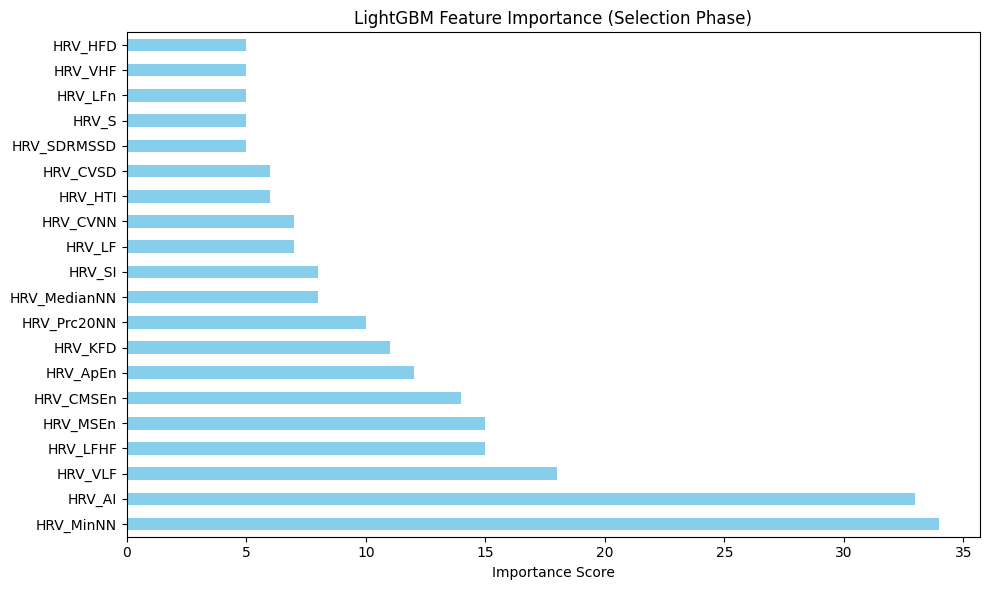

In [14]:
# Feature Selection with LightGBM



feature_selector = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(
        LGBMClassifier(
            random_state=42,
            n_jobs=-1,
            max_depth=3,
            n_estimators=50,
            verbose=-1
        ),
        max_features=20,
        threshold=-np.inf  # Ensure we get exactly 20 features
    ))
])

feature_selector.fit(X_train, y_train)

# Get selected features
selected_mask = feature_selector.named_steps['selector'].get_support()
selected_features = X_train.columns[selected_mask]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]



# Visualize selection importance
selector_model = feature_selector.named_steps['selector'].estimator_
importances = pd.Series(
    selector_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(20).plot.barh(color='skyblue')
plt.title("LightGBM Feature Importance (Selection Phase)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


# EDA

In [15]:
# Inverse transform (recover original labels)
original_labels = label_encoder.inverse_transform(data['label'])


# Prepare DataFrame for bivariate plots
data['label_inverse'] = original_labels
selected_data = data[selected_features.tolist()].copy()
selected_data['label_inverse'] = data['label_inverse'].astype('category')

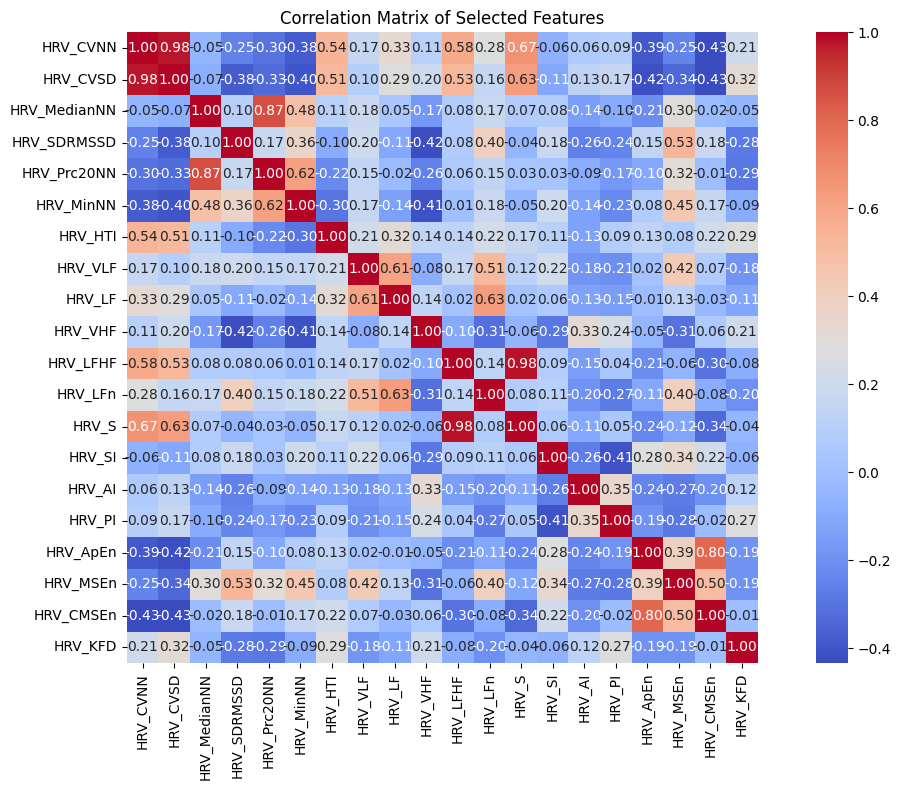

In [16]:
# Correlation Matrix for Selected Features



# Calculate correlation matrix
corr_matrix = selected_data.drop(columns=['label_inverse']).corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Selected Features")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/loca

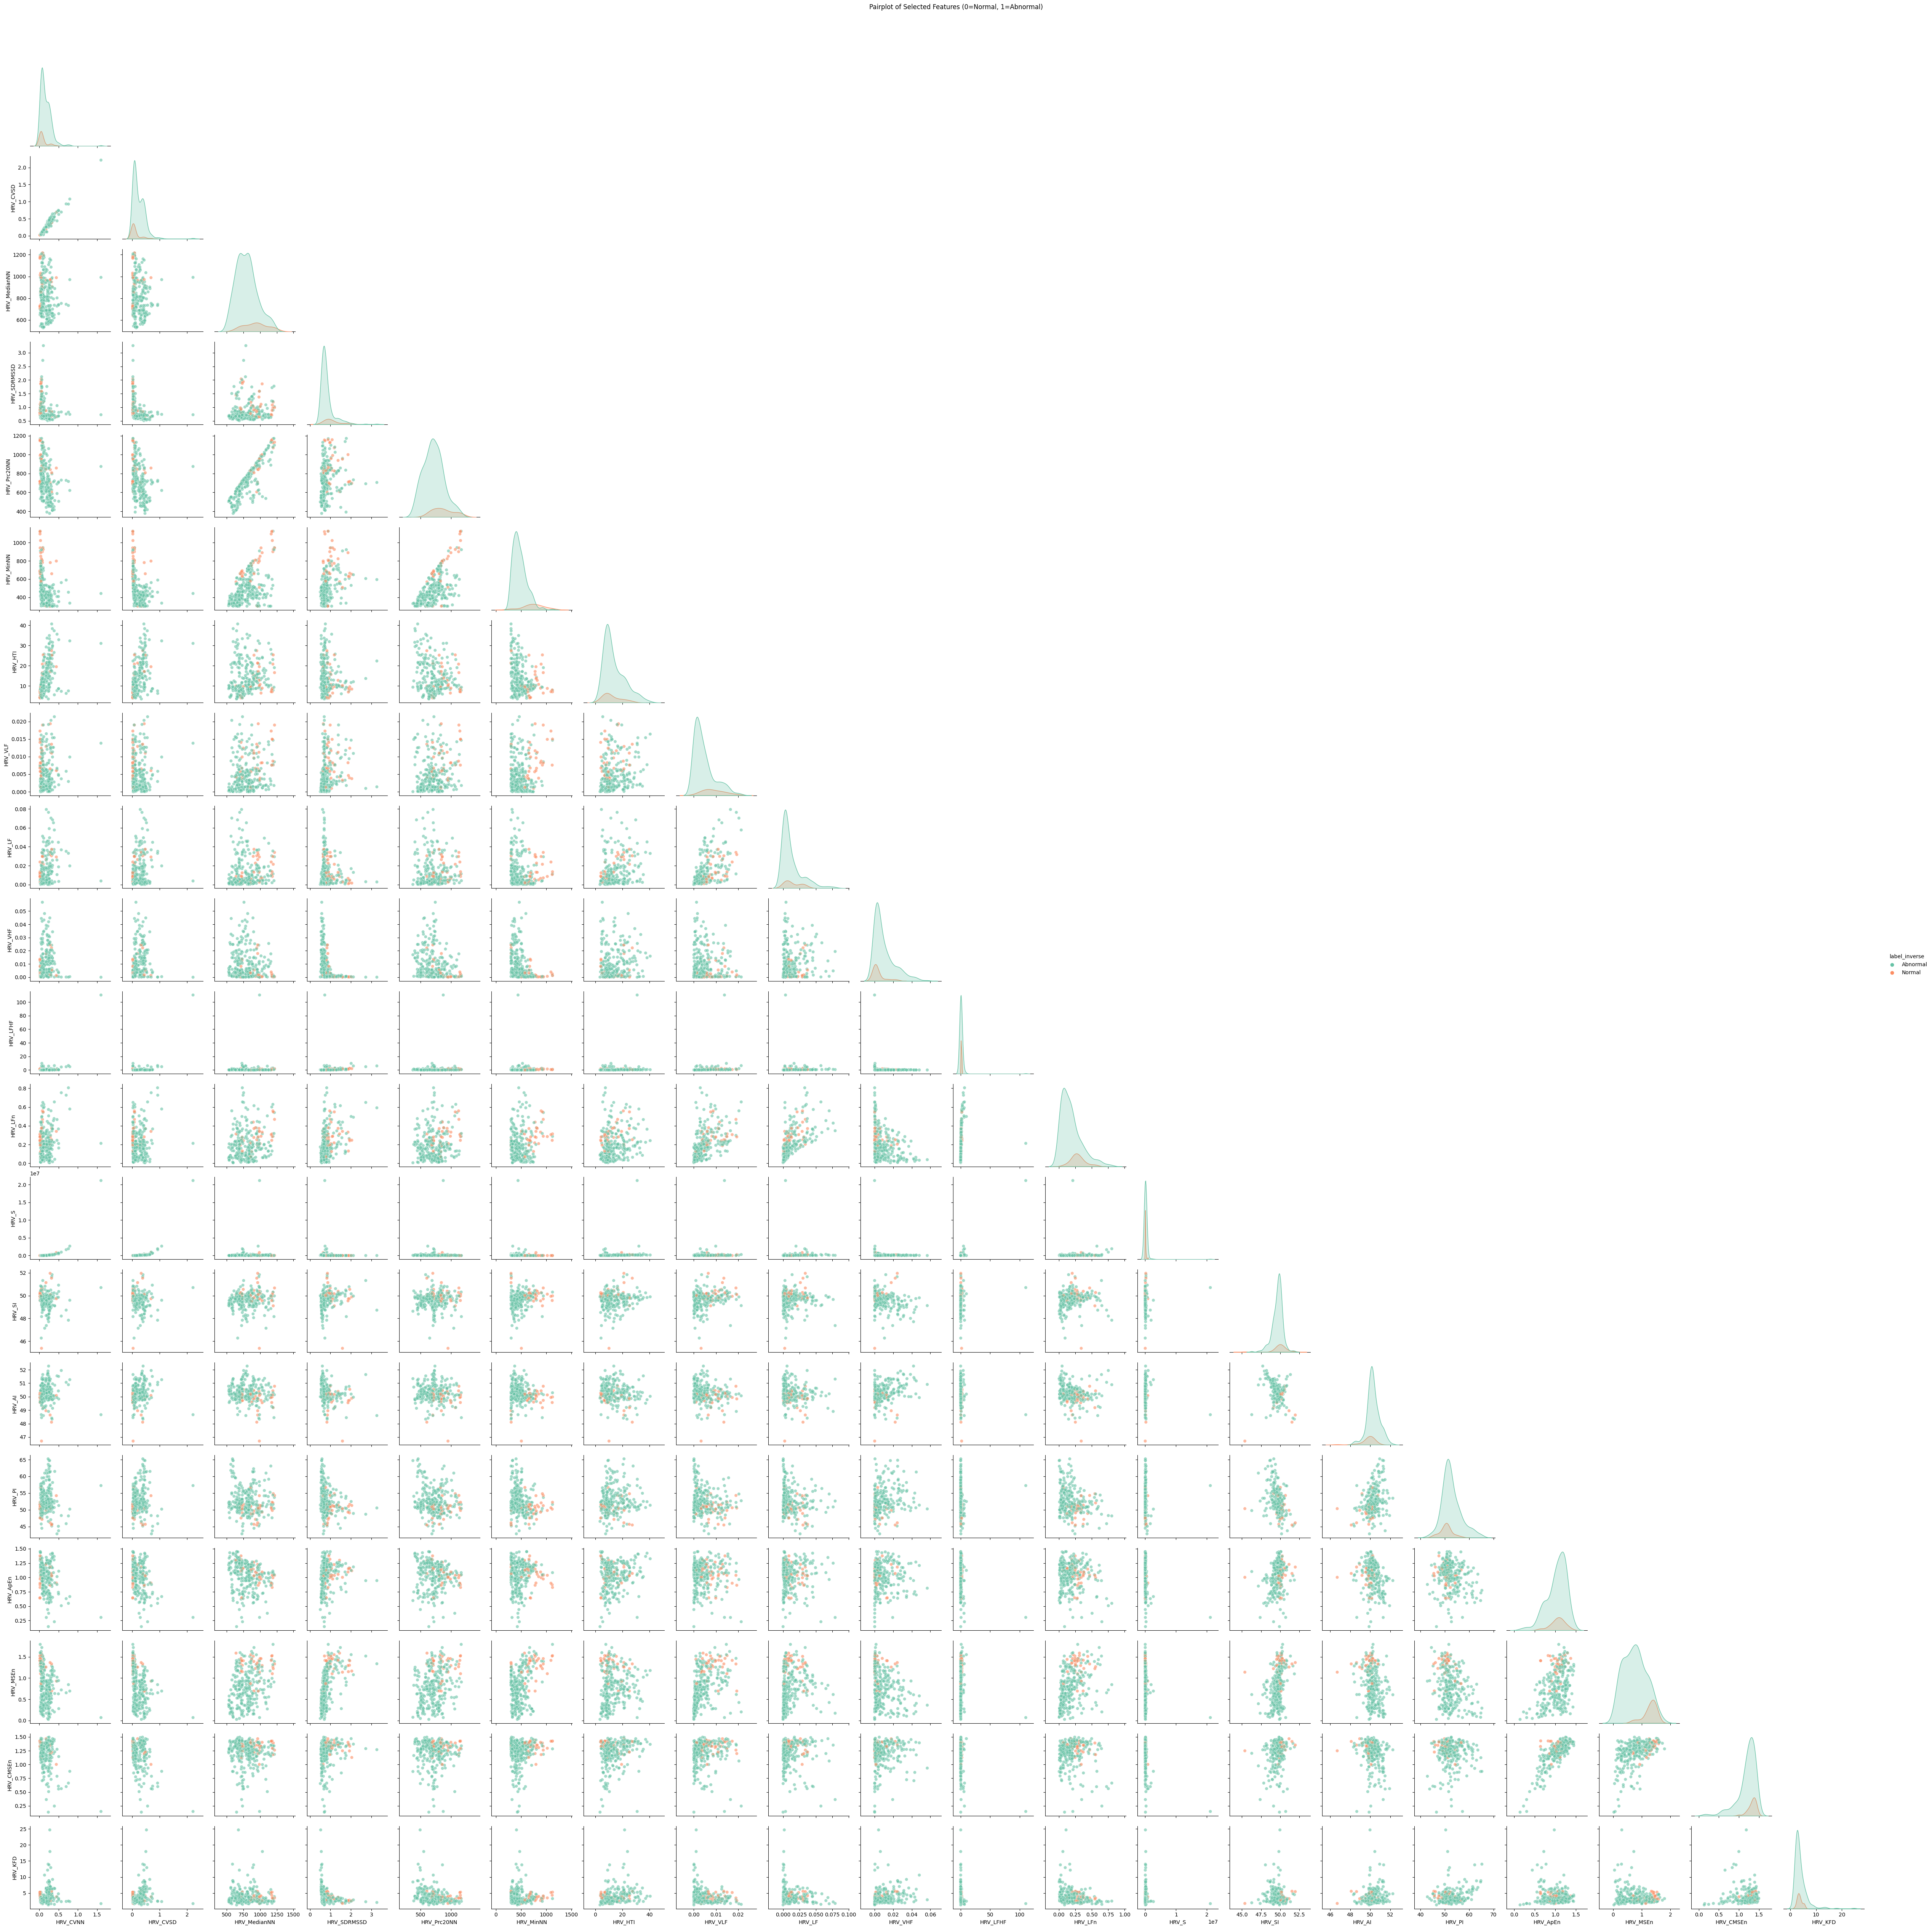

In [17]:
# Pairplot (may be slow for many features)
sns.pairplot(selected_data, hue='label_inverse', corner=True, palette='Set2', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Selected Features (0=Normal, 1=Abnormal)", y=1.02)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



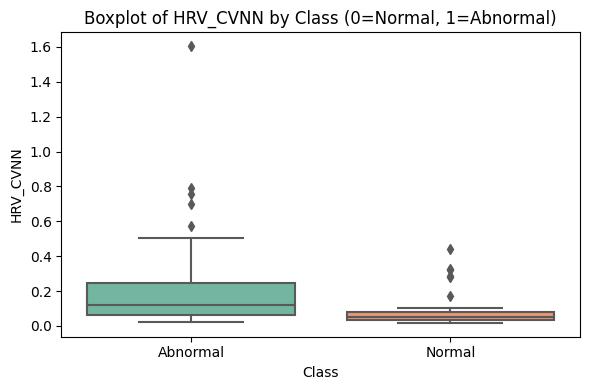

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



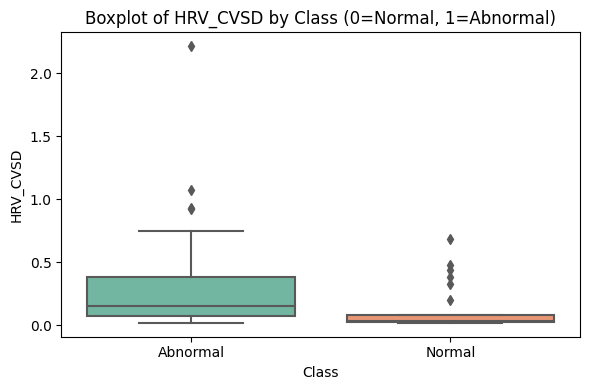

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



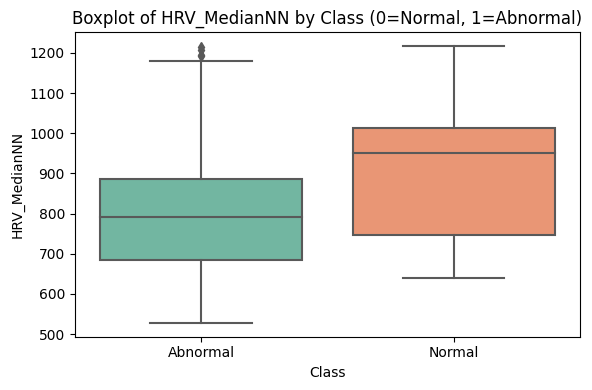

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



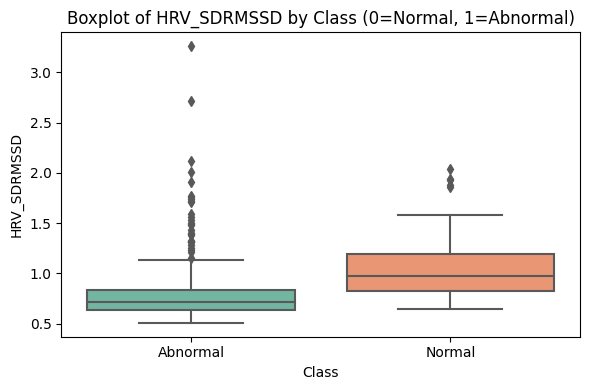

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



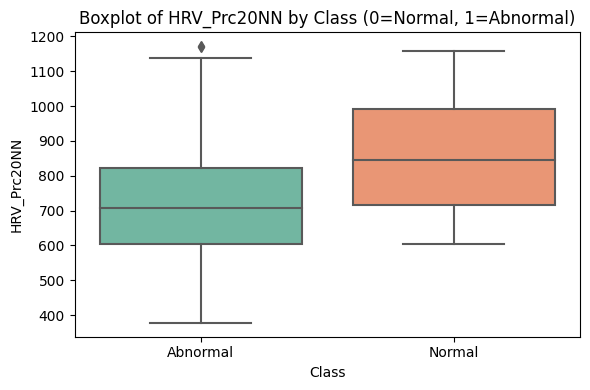

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



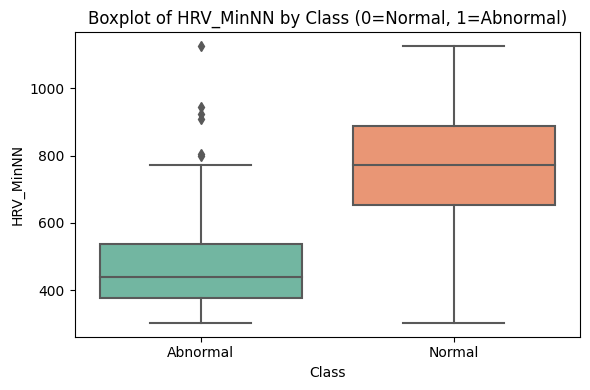

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



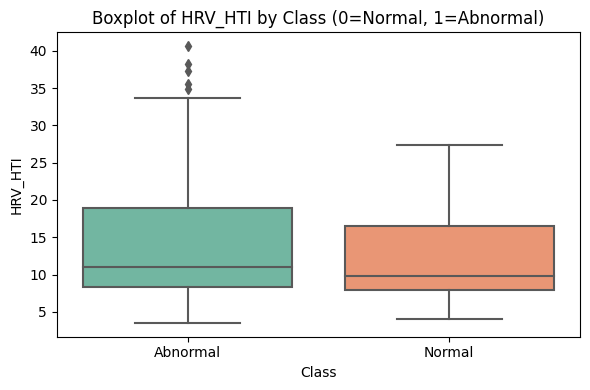

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



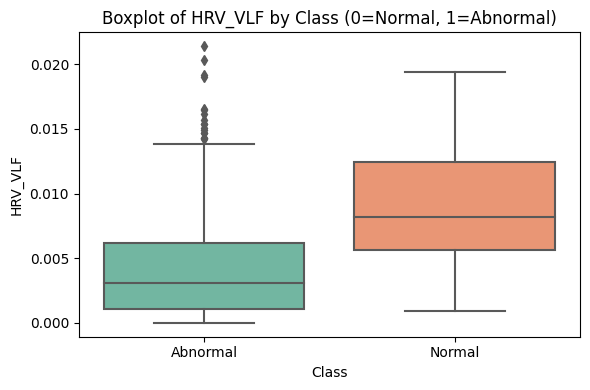

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



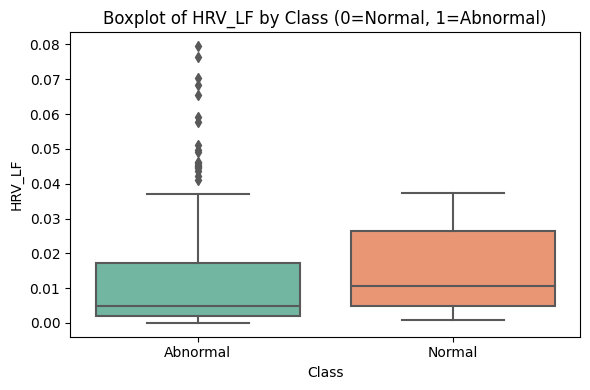

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



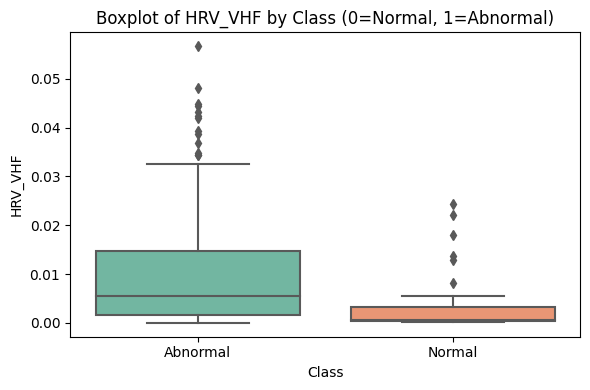

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



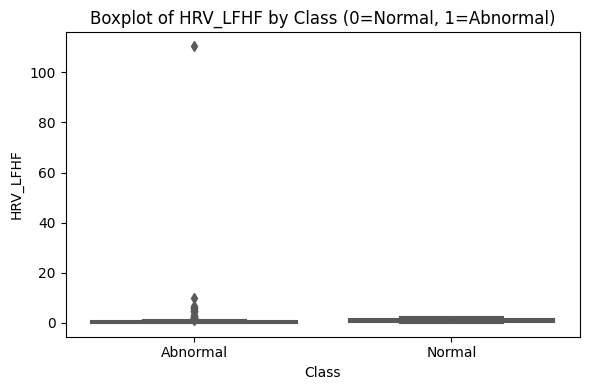

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



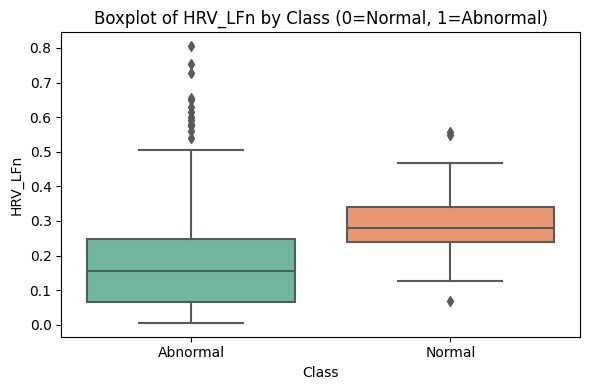

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



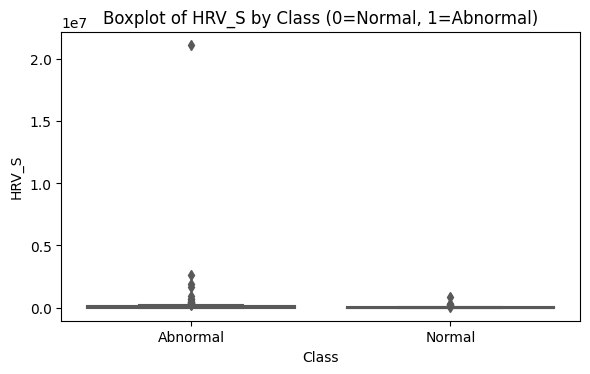

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



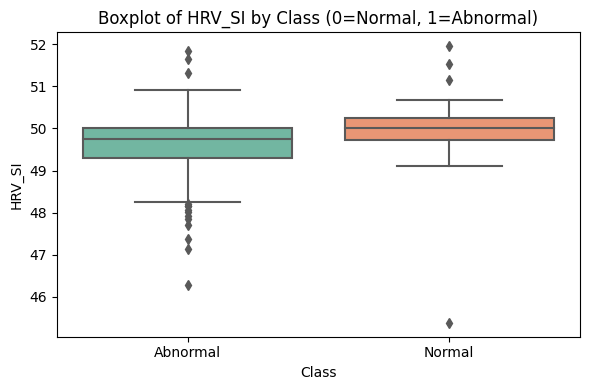

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



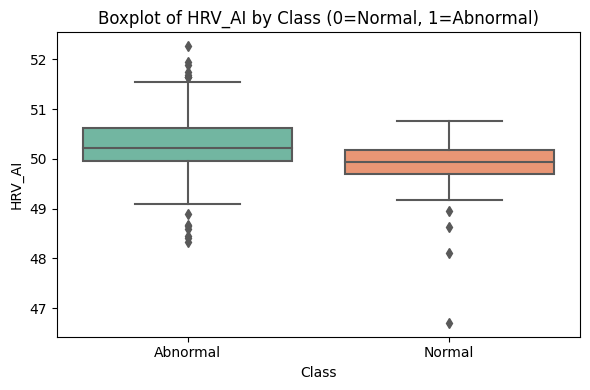

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



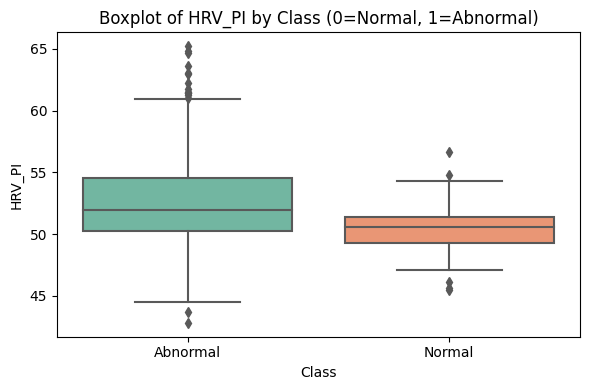

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



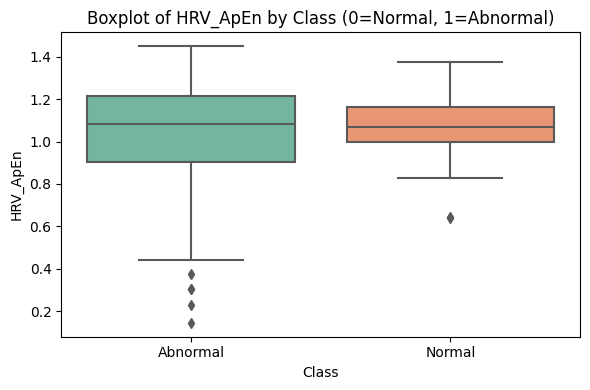

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



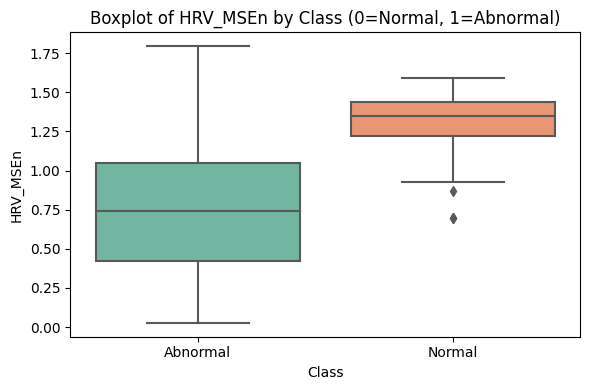

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



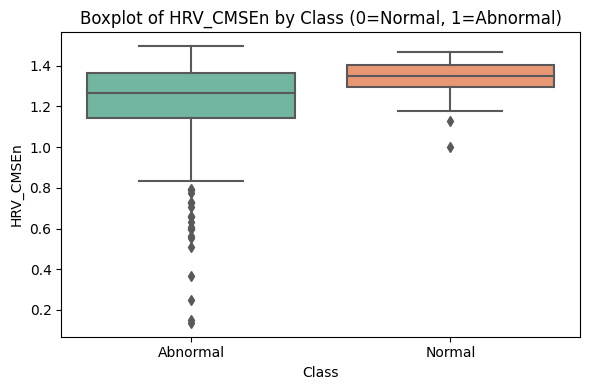

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



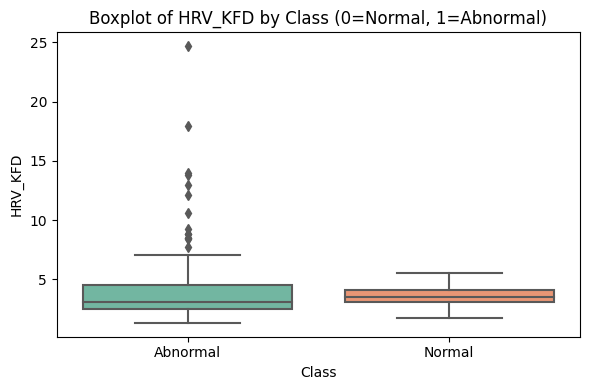

In [18]:
# Boxplots for each selected feature
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='label_inverse', y=feature, data=selected_data, palette='Set2')
    plt.title(f"Boxplot of {feature} by Class (0=Normal, 1=Abnormal)")
    plt.xlabel("Class")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



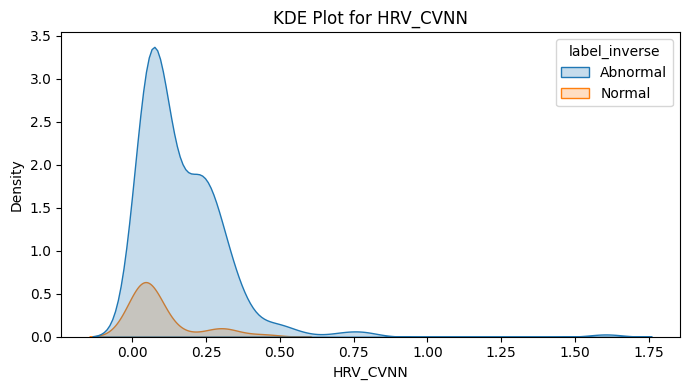

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



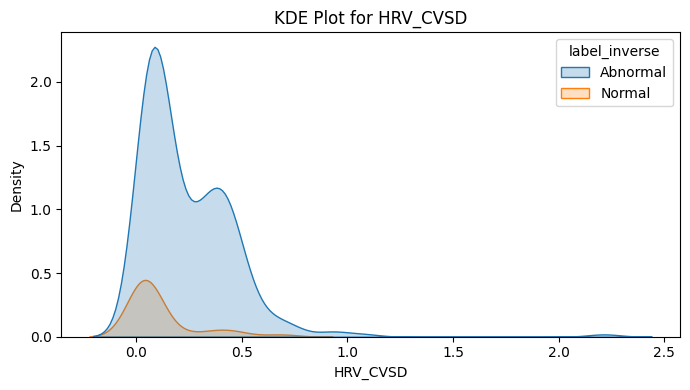

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



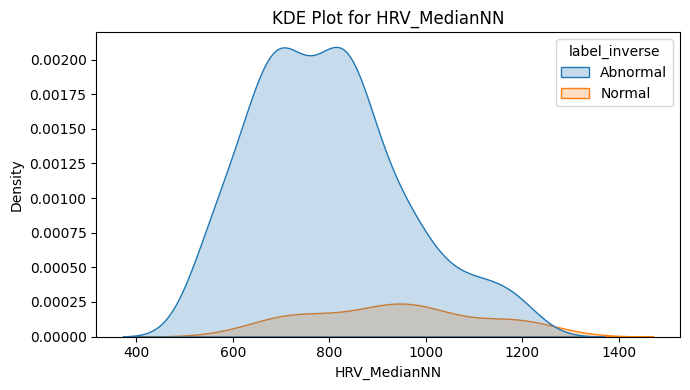

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



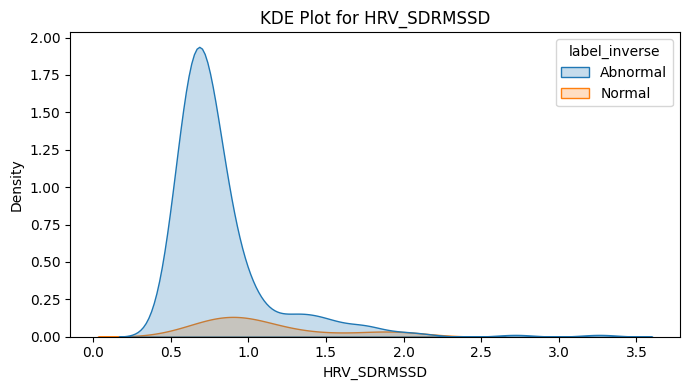

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



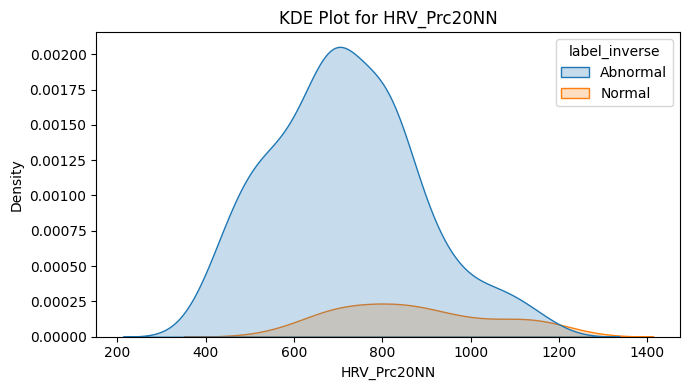

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



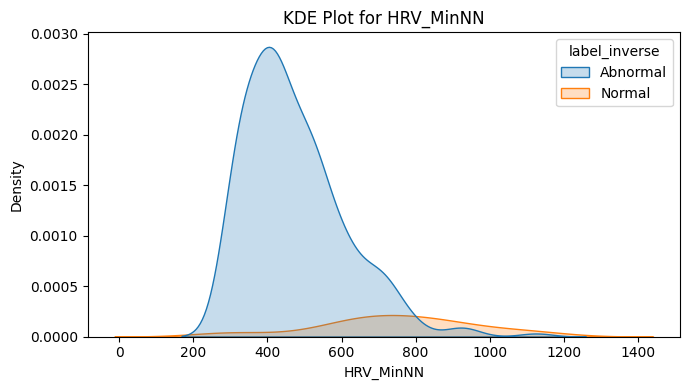

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



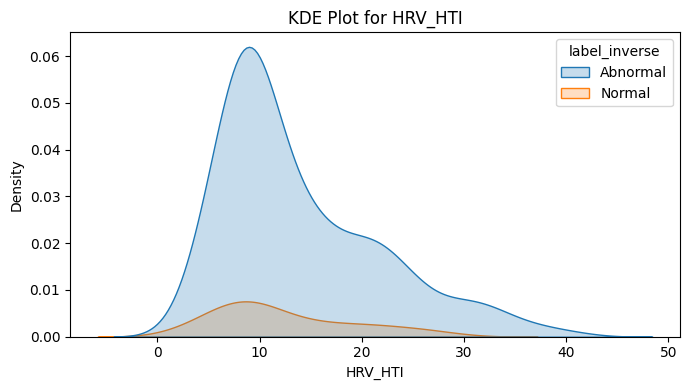

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



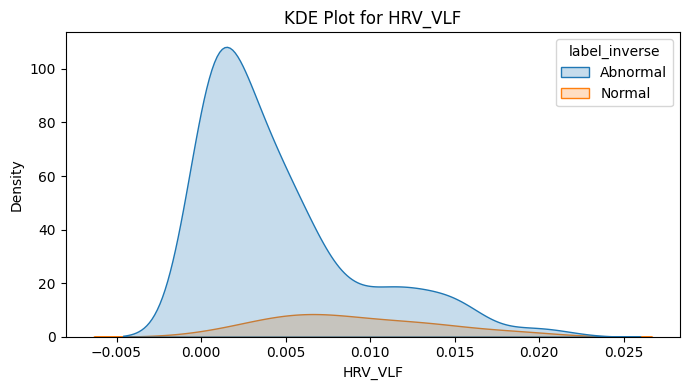

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



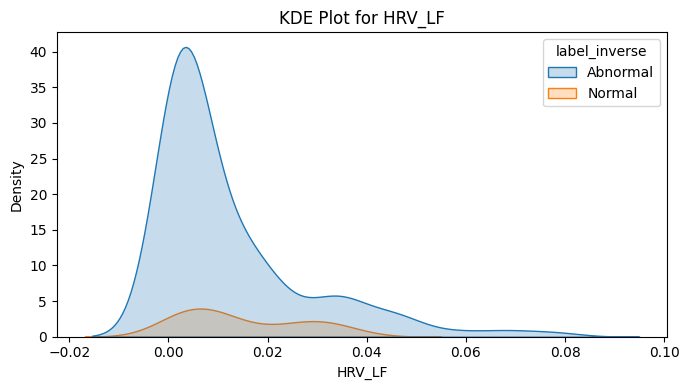

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



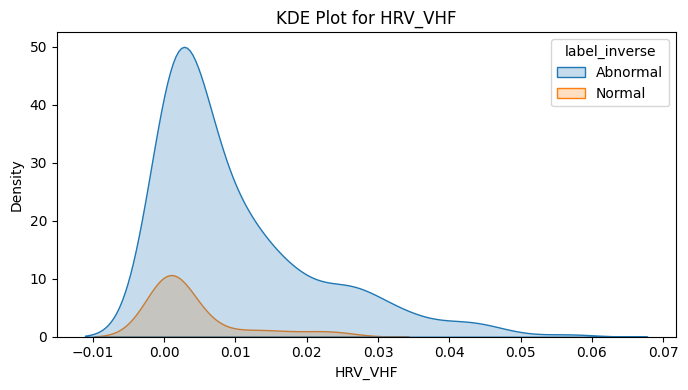

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



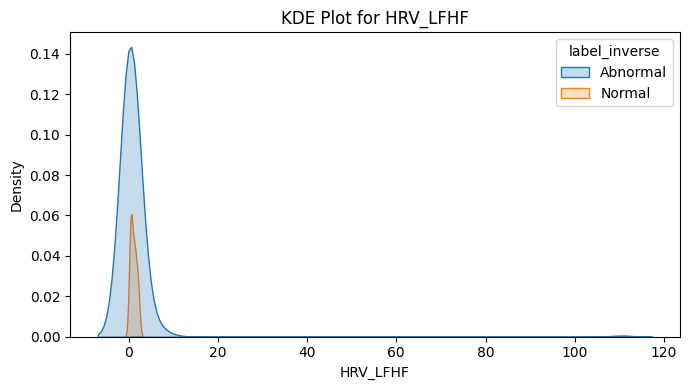

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



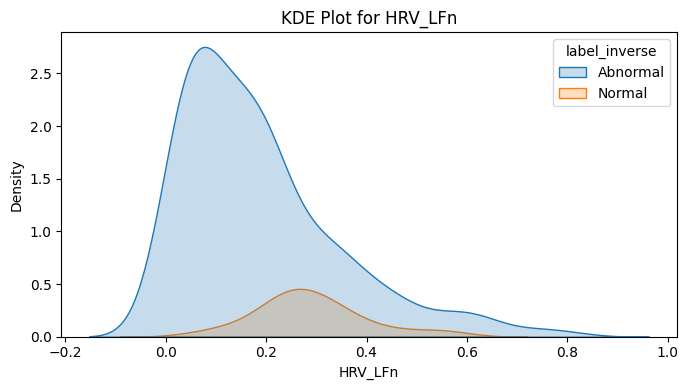

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



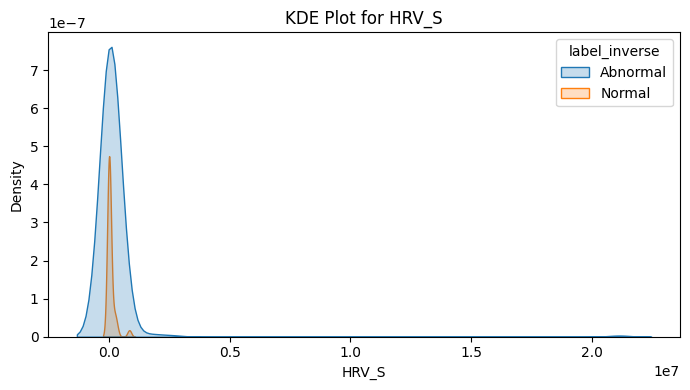

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



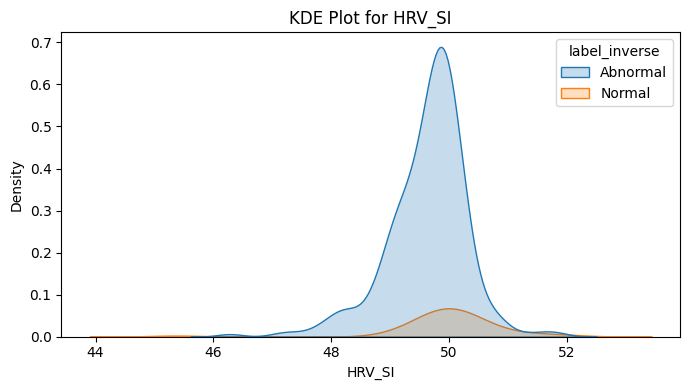

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



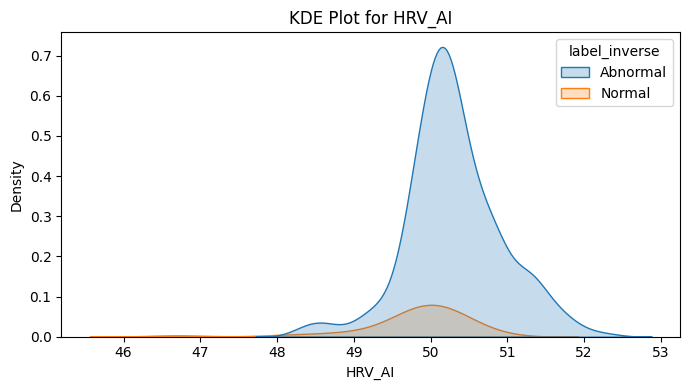

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



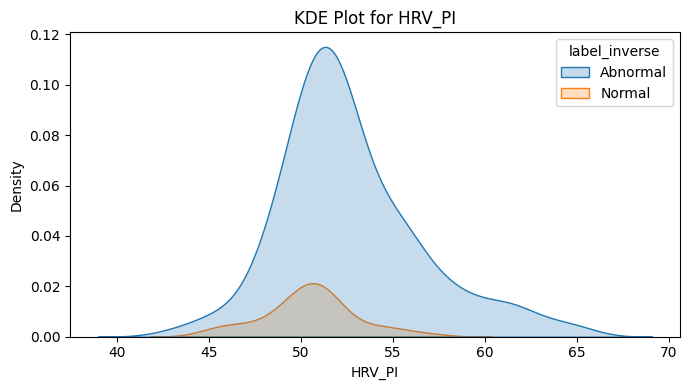

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



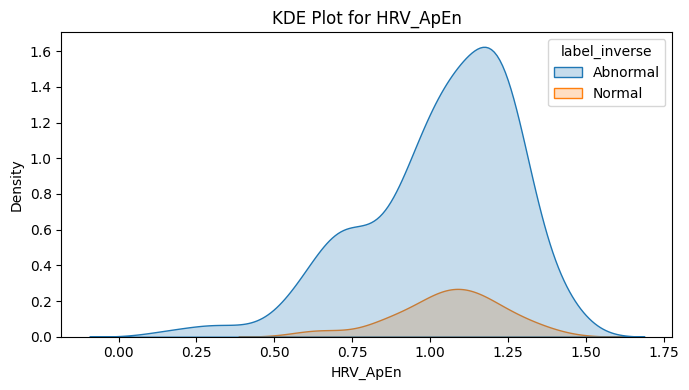

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



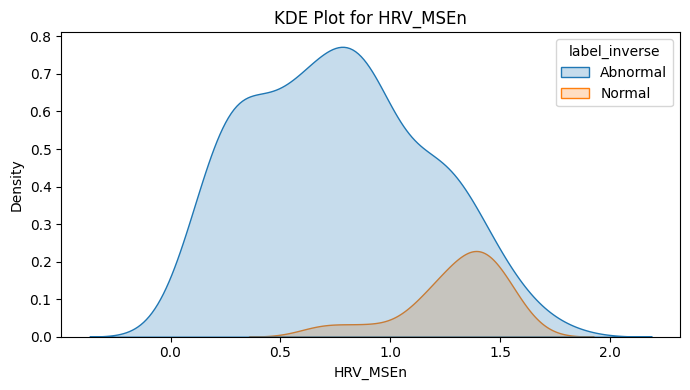

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



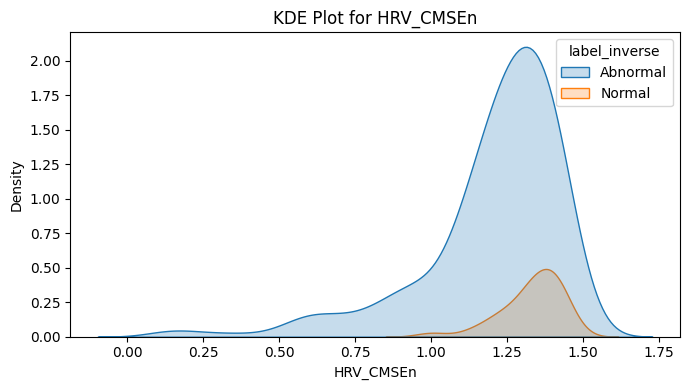

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



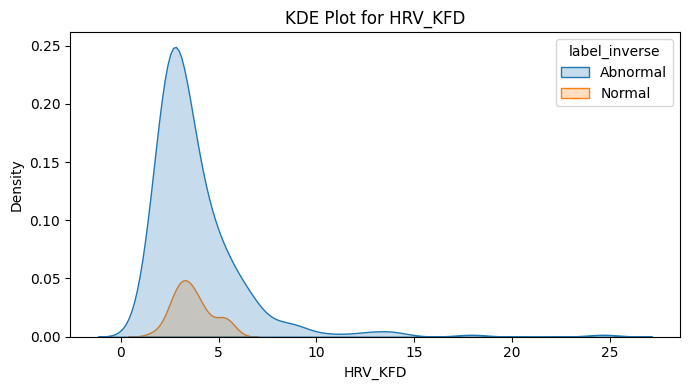

In [19]:
for col in selected_features:
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=selected_data, x=col, hue='label_inverse', fill=True)
    plt.title(f"KDE Plot for {col}")
    plt.tight_layout()
    plt.show()


# Classification

## Hyperparameter Tuning

In [20]:
# ======================================================================
# PHASE 2: Hyperparameter Tuning with Selected Features
# ======================================================================

from sklearn.metrics import confusion_matrix
print("\n=== PHASE 2: Hyperparameter Tuning ===\n")

tuning_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 0.8]
}

grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_sel, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:25}: {value}")

# Test set performance
y_pred = best_model.predict(X_test_sel)
y_proba = best_model.predict_proba(X_test_sel)[:, 1]

print("\n=== Final Test Performance ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()  # assumes binary classification
specificity = tn / (tn + fp)


print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")



=== PHASE 2: Hyperparameter Tuning ===

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse



Best Parameters:
classifier__max_depth    : 10
classifier__max_features : sqrt
classifier__min_samples_split: 2
classifier__n_estimators : 200

=== Final Test Performance ===
              precision    recall  f1-score   support

    Abnormal       0.97      0.90      0.93        77
      Normal       0.90      0.97      0.94        76

    accuracy                           0.93       153
   macro avg       0.94      0.93      0.93       153
weighted avg       0.94      0.93      0.93       153

ROC-AUC: 0.98
Accuracy: 0.93


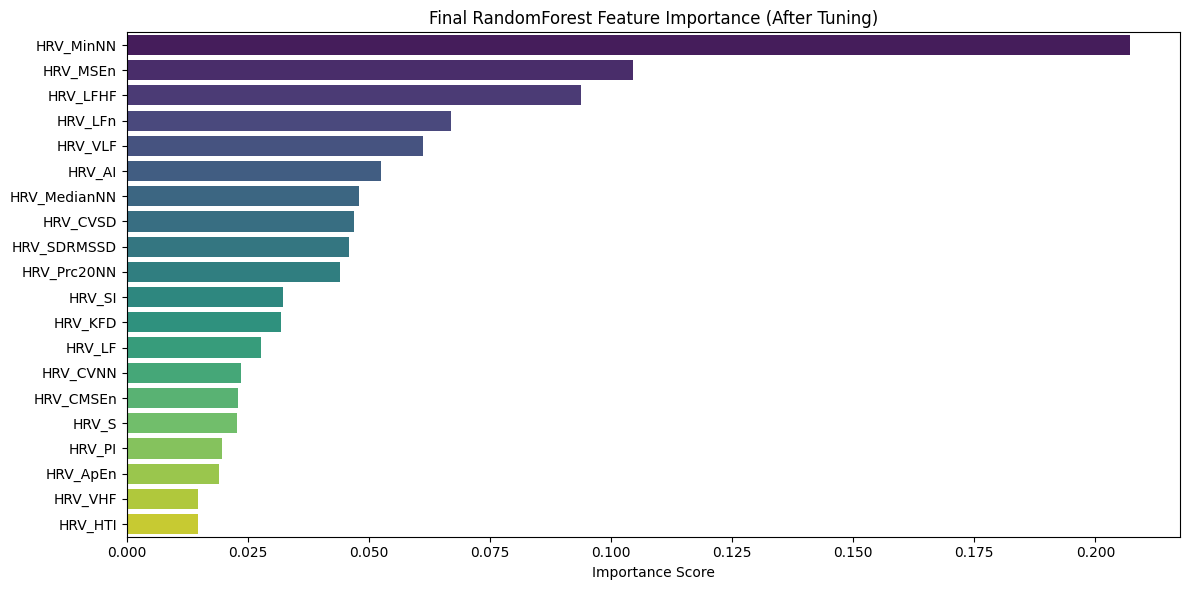

In [21]:
# Final feature importance
final_rf = best_model.named_steps['classifier']
final_importances = pd.Series(
    final_rf.feature_importances_,
    index=selected_features
).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=final_importances.values,
    y=final_importances.index,
    palette='viridis'
)
plt.title("Final RandomForest Feature Importance (After Tuning)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()



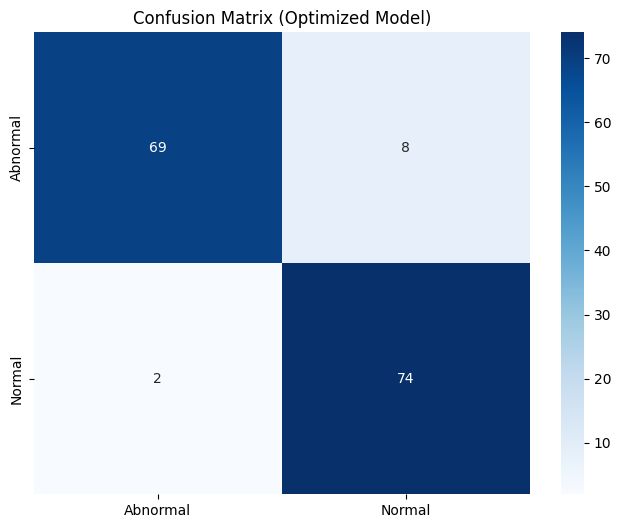

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Optimized Model)")
plt.show()

# Explainability AI

In [23]:
import shap
import pandas as pd

# Extract the classifier from the pipeline
rf_model = best_model.named_steps['classifier']

# Ensure X_test_sel and X_train_sel are DataFrames with the same columns
X_test_df = pd.DataFrame(X_test_sel, columns=X_train_sel.columns)
X_train_df = pd.DataFrame(X_train_sel, columns=X_train_sel.columns)

# Create SHAP explainer using the classifier and training data
explainer = shap.Explainer(rf_model.predict_proba, X_train_df)

# Compute SHAP values for test set
shap_values = explainer(X_test_df)

# Display SHAP value shape info
print(f"SHAP values shape: {shap_values.values.shape}")  # (n_samples, n_features, n_classes)

# Extract SHAP values for class 1
class1_shap_values = shap_values.values[:, :, 1]
print(f"SHAP values for class 1 shape: {class1_shap_values.shape}")


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

SHAP values shape: (153, 20, 2)
SHAP values for class 1 shape: (153, 20)


SHAP values shape: (153, 20, 2)
SHAP values for class 1 shape: (153, 20)


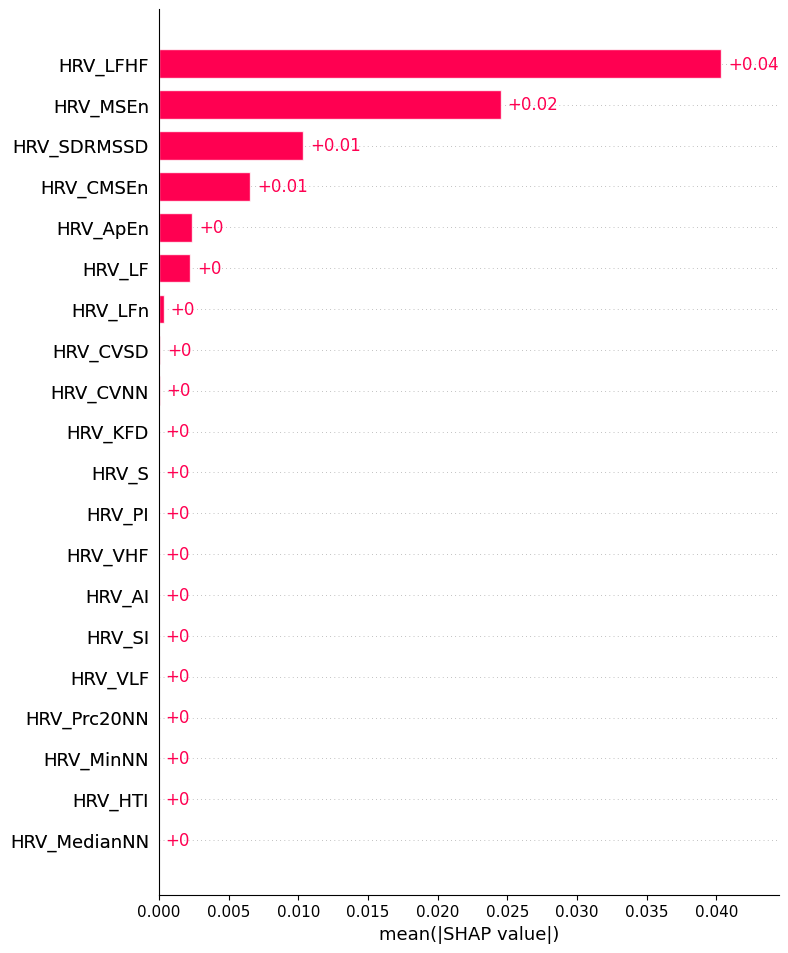

In [24]:
import shap
import pandas as pd

# Extract the classifier from the pipeline
rf_model = best_model.named_steps['classifier']

# Ensure X_test_sel and X_train_sel are DataFrames with the same columns
X_test_df = pd.DataFrame(X_test_sel, columns=X_train_sel.columns)
X_train_df = pd.DataFrame(X_train_sel, columns=X_train_sel.columns)

# Create SHAP explainer using the classifier and training data
explainer = shap.Explainer(rf_model, X_train_df)

# Compute SHAP values for test set
shap_values = explainer(X_test_df)

# Display SHAP value shape info
print(f"SHAP values shape: {shap_values.values.shape}")  # (n_samples, n_features, n_classes)

# Extract SHAP values for class 1
class1_shap_values = shap_values[..., 1]
print(f"SHAP values for class 1 shape: {class1_shap_values.values.shape}")

# Create an Explanation object for class 1
class1_expl = shap.Explanation(
    values = class1_shap_values.values,
    base_values = class1_shap_values.base_values,
    data = class1_shap_values.data,
    feature_names = class1_shap_values.feature_names
)

# Now display the bar plot using the new Explanation object
shap.plots.bar(class1_expl, max_display=X_test.shape[1])


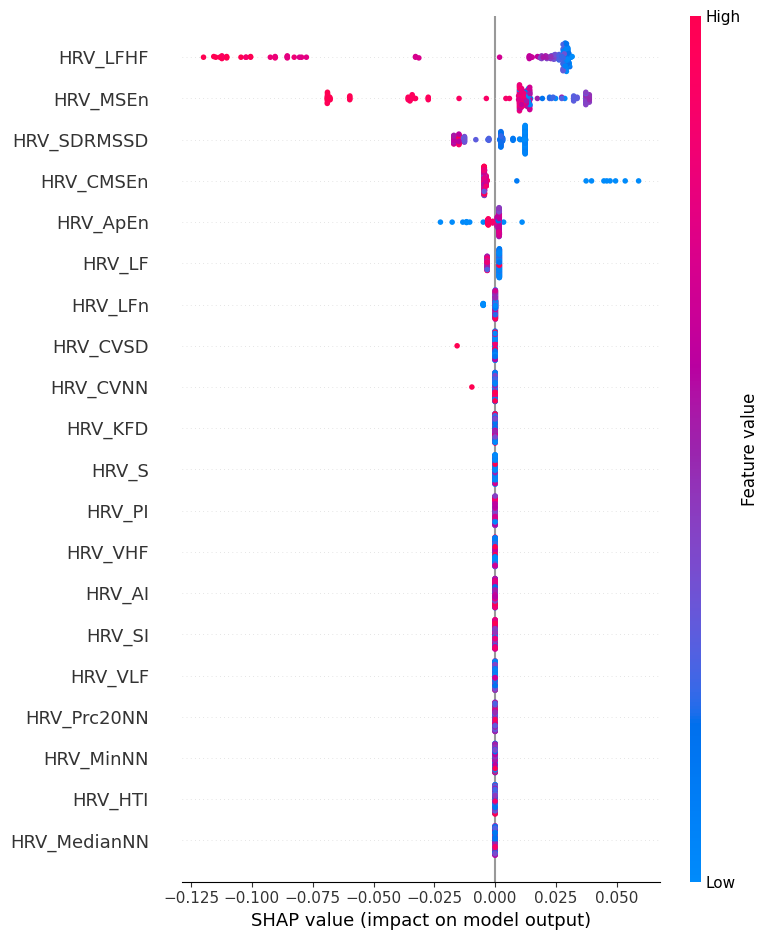

In [25]:
# Create a summary plot for the positive class (class 1)
shap.summary_plot(class1_shap_values.values, X_test_df, feature_names=class1_shap_values.feature_names)


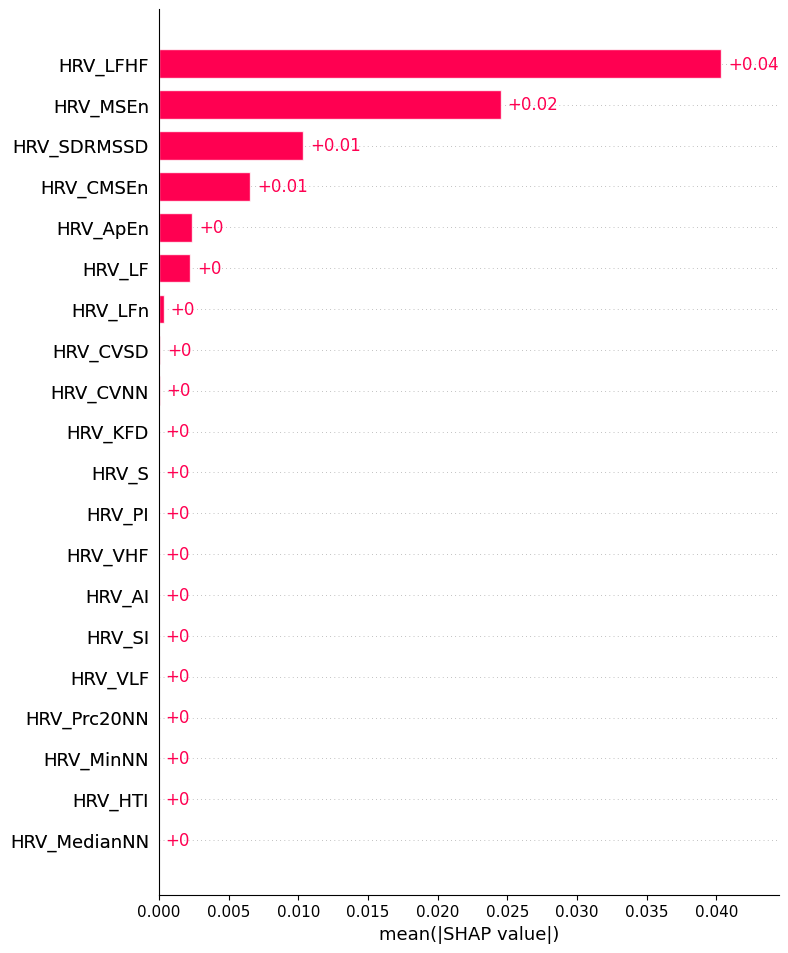

In [26]:
# Create an Explanation object for class 0
class0_shap_values = shap.Explanation(
    values=shap_values.values[:, :, 0],
    base_values=shap_values.base_values[:, 0] if shap_values.base_values.ndim > 1 else shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# Display the bar plot for class 0
shap.plots.bar(class0_shap_values, max_display=X_test_df.shape[1])


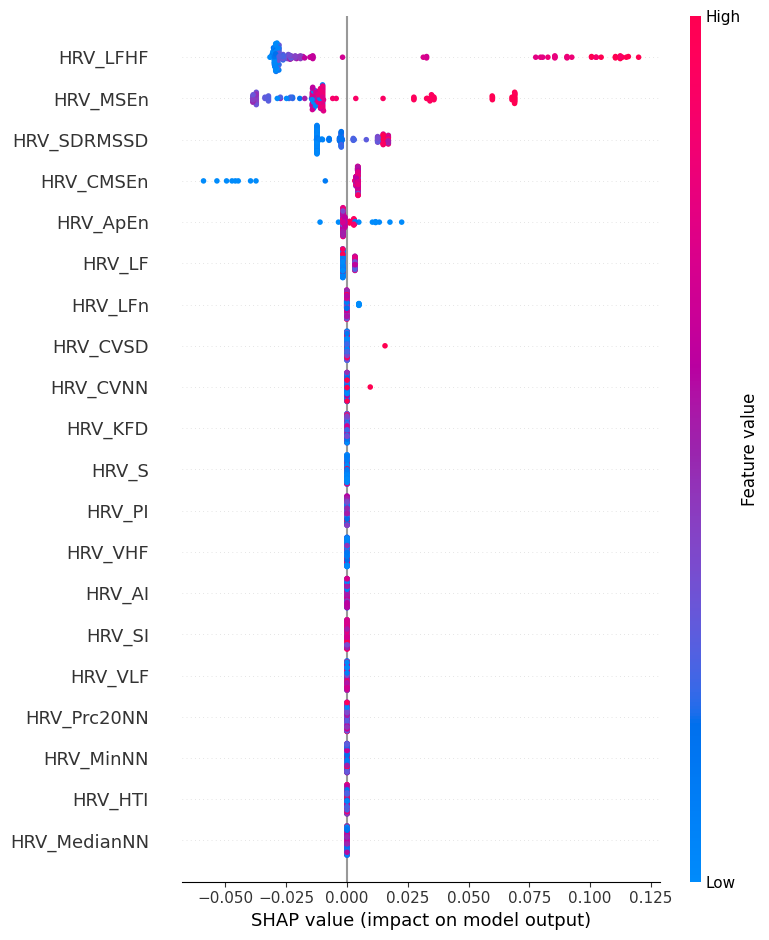

In [27]:
# Create a summary plot for class 0 using the updated Explanation object
shap.summary_plot(class0_shap_values.values, X_test_df, feature_names=class0_shap_values.feature_names)


In [28]:
# Load JavaScript for visualization
shap.initjs()

# Select the first instance (index 0) and class 1 SHAP Explanation
instance_index = 0

# Use the Explanation object for class 1
class1_expl = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1] if shap_values.base_values.ndim > 1 else shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# Generate force plot for the selected instance
shap.force_plot(
    base_value=class1_expl.base_values[instance_index],
    shap_values=class1_expl.values[instance_index],
    features=class1_expl.data[instance_index],
    feature_names=class1_expl.feature_names
)


In [29]:

class_index = 0
# Create an Explanation object for the specific class
shap_expl = shap.Explanation(
    values=shap_values.values[:, :, class_index],  # Extract values for the chosen class
    base_values=shap_values.base_values[:, class_index] if shap_values.base_values.ndim > 1 else shap_values.base_values,
    data=X_test_sel,
    feature_names=X_test_sel.columns
)

# Optional: Visualize more instances (e.g., first 5) using a multi-instance force plot
multi_instance_indices = range(5)  # You can adjust this range as needed

# Create the multi-instance force plot using the same shap_expl object
shap.force_plot(
    base_value=shap_expl.base_values[multi_instance_indices],
    shap_values=shap_expl.values[multi_instance_indices],
    features=shap_expl.data.iloc[multi_instance_indices],
    feature_names=shap_expl.feature_names
)


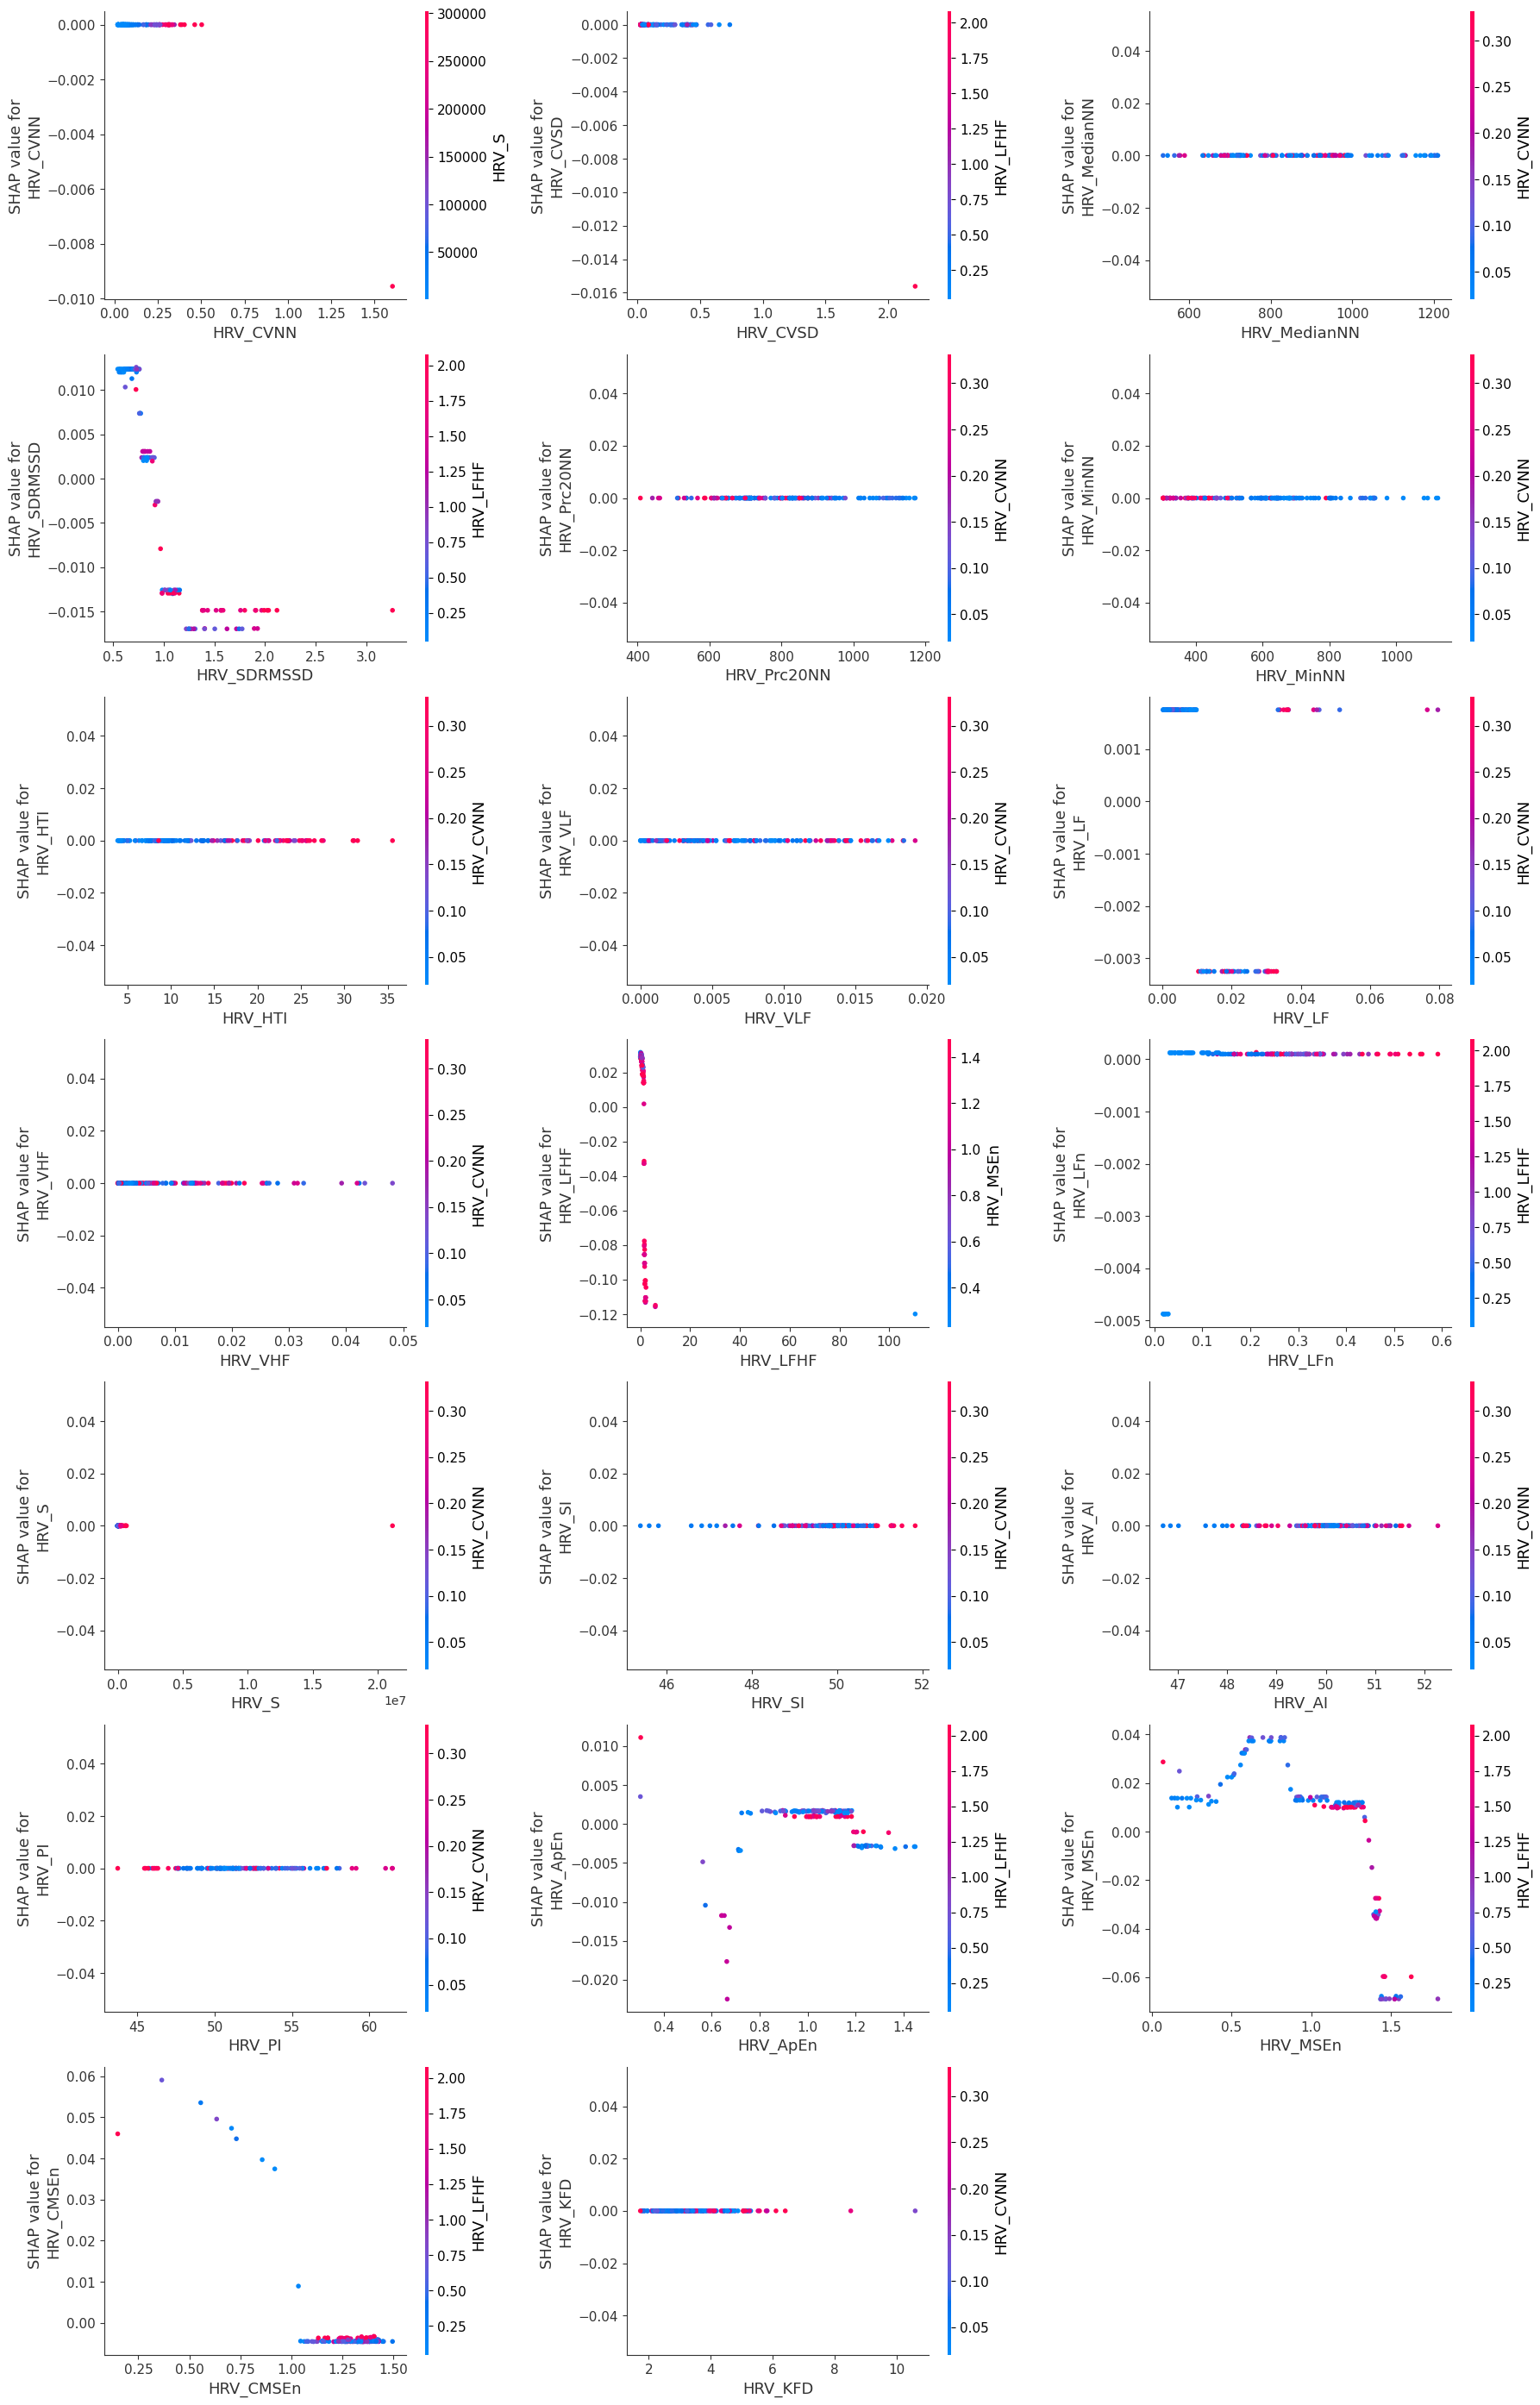

In [30]:
shap.initjs()  # Load JavaScript for visualization

# Define the number of columns per row
col_num = 3
rows_num = (len(X_test_sel.columns) + col_num - 1) // col_num  # Calculate needed rows

fig, axes = plt.subplots(nrows=rows_num, ncols=col_num, figsize=(6 * col_num, 4 * rows_num))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Extract SHAP values for class 1 (modify if needed)
class_index = 1  # Set to 0 if you want to plot for class 0
shap_values_class = shap_values.values[:, :, class_index]



# Ensure SHAP values match the number of features in X_test_sel
assert shap_values_class.shape[1] == X_test_sel.shape[1], \
    f"SHAP values have {shap_values_class.shape[1]} columns, but X_test_sel has {X_test_sel.shape[1]} columns!"

# Loop through each feature to generate the dependence plots
for i, feature in enumerate(X_test_sel.columns):
    shap.dependence_plot(
        feature,  # Feature for which we are plotting the dependence
        shap_values_class,  # SHAP values for the selected class
        X_test_sel,  # Input data (test data)
        ax=axes[i],  # Axes for plotting
        show=False  # Avoid automatic display (we handle this at the end)
    )

# Remove empty subplots if there are any extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots
